### Git versioning

In [3]:
import git  #Requires Gitpython installed, to install do "$ pip install Gitpython" in your terminal
import pkg_resources
openfisca_france_location = pkg_resources.get_distribution('openfisca-france').location
repo = git.Repo(openfisca_france_location)
repo.git.status()

sha = repo.head.object.hexsha

print "---This notebook have been runed with--- \n","Openfisca-france :", repo.head.object.hexsha, '\n' 
print "Commit short SHA:", repo.git.rev_parse(sha, short=4)
print "Branch: ", repo.git.rev_parse('--abbrev-ref', "HEAD") #equivalent to: $git rev-parse --abbrev-ref HEAD
print "Date (y/m/d):", repo.git.show("-s", '--format=%ci', 'HEAD^')[:-5],"\n"  # equivalent to: $git show -s --format=%ci HEAD^

print "Openfisca-core :", git.Repo(pkg_resources.get_distribution('openfisca-core').location).head.object.hexsha, ' Date:', git.Repo(pkg_resources.get_distribution('openfisca-core').location).git.show("-s", '--format=%ci', 'HEAD^')[:-5]
print "Openfisca-france-data :", git.Repo(pkg_resources.get_distribution('openfisca-france-data').location).head.object.hexsha, ' Date:', git.Repo(pkg_resources.get_distribution('openfisca-france-data').location).git.show("-s", '--format=%ci', 'HEAD^')[:-5]
print "OpenFisca-Aggregates :", git.Repo(pkg_resources.get_distribution('OpenFisca-Aggregates').location).head.object.hexsha, ' Date:', git.Repo(pkg_resources.get_distribution('OpenFisca-Aggregates').location).git.show("-s", '--format=%ci', 'HEAD^')[:-5]
print "OpenFisca-Survey-Manager :", git.Repo(pkg_resources.get_distribution('OpenFisca-Survey-Manager').location).head.object.hexsha, ' Date:', git.Repo(pkg_resources.get_distribution('OpenFisca-Aggregates').location).git.show("-s", '--format=%ci', 'HEAD^')[:-5]

---This notebook have been runed with--- 
Openfisca-france : f710f63abb52a3395a126bd96e0f3f4bfd83d1a6 

Commit short SHA: f710
Branch:  mensualisation_wip
Date (y/m/d): 2016-07-26 13:55:47  

Openfisca-core : 4076f591f4bcb571391b65a989e1603fdc4cb759  Date: 2016-02-24 16:11:57 
Openfisca-france-data : a6b02e6909ee9c27169cd5cf73c51df9b1640ef9  Date: 2016-05-31 15:54:47 
OpenFisca-Aggregates : fd210d8cfdf6ed68f173d9d5c3eab4a4302ed2b9  Date: 2016-04-04 11:35:03 
OpenFisca-Survey-Manager : 868512d24307aa75cfa7bbbf8420542960963966  Date: 2016-04-04 11:35:03 


### Imports

In [4]:
%matplotlib inline
from __future__ import division

import calendar

from openfisca_core import periods
from openfisca_plugin_aggregates.tests.reform.test_aggregates_mensualized import create_survey_scenario
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator


import numpy as np
from numpy import (datetime64, logical_and as and_, logical_not as not_, logical_or as or_, logical_xor as xor_,
maximum as max_, minimum as min_, round)


#Faire des filtres pour Mahdi survey_scenario.create_data_frame_by_entity_key_plural

pd.set_option('expand_frame_repr', False)  #utile quand on utilise pandas en mode console
pd.set_option("display.max_rows",201)
pd.set_option("display.max_columns",201)

/usr/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: During startup - 
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 1: Setting LC_COLLATE failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 2: Setting LC_TIME failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 3: Setting LC_MESSAGES failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 4: Setting LC_MONETARY failed, using "C" 

  warnings.warn(x, RRuntimeWarning)


# Create Survey Scenario

In [5]:
period = periods.period(2009)

In [6]:
period.this_year.this_month

Period((u'month', Instant((2009, 1, 1)), 1))

In [7]:
survey_scenario = create_survey_scenario(2009)
survey_scenario.new_simulation()


simulation = survey_scenario.simulation
scenario = survey_scenario

weight_foyers = survey_scenario.simulation.calculate_add('weight_foyers', period = period).astype(float)
weight_menages = survey_scenario.simulation.calculate_add('wprm', period = period).astype(float)
weight_familles = survey_scenario.simulation.calculate_add('weight_familles', period = period).astype(float)
weight_individus = survey_scenario.simulation.calculate_add('weight_individus', period = period).astype(float)
print weight_foyers.shape, weight_menages.shape, weight_familles.shape, weight_individus.shape

(59874,) (49016,) (55306,) (112359,)


In [8]:
def sum_by_entity(var, entity_key, roles = None):
    var_holder = simulation.compute_add(var)
    entity = simulation.entity_by_key_singular[entity_key]
    
    entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
    
    if roles is None:
        roles = range(10)
    
    target_array = np.empty(entity.count)
    target_array.fill(0)            
    for role in roles:  #max cardinality of roles
        boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
        target_array[entity_index_array[boolean_filter]] += var_holder.array[boolean_filter]
    return target_array



def sum_array_by_entity(array, entity_key, roles = None):
    entity = simulation.entity_by_key_singular[entity_key]
    entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
    if roles is None:
        roles = range(10)
    
    target_array = np.empty(entity.count)
    target_array.fill(0)            
    for role in roles:  #max cardinality of roles
        boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
        target_array[entity_index_array[boolean_filter]] += array[boolean_filter]
    return target_array
    

def cast_from_entity_to_role( var , roles = None):
    var_holder = simulation.compute_add(var)
    entity = var_holder.entity
    entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
    if roles is None:
        roles = range(entity.roles_count)
    target_array = np.empty(simulation.persons.count)
    target_array.fill(0)
    for role in roles:
        boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
        target_array[boolean_filter] = simulation.compute_add(var).array[entity_index_array[boolean_filter]]
    return target_array

def cast_array_from_entity_to_role( array, entity_key, roles = None):
    entity = simulation.entity_by_key_singular[entity_key]
    entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
    if roles is None:
        roles = range(entity.roles_count)
    target_array = np.empty(simulation.persons.count)
    target_array.fill(0)
    for role in roles:
        boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
        target_array[boolean_filter] = array[entity_index_array[boolean_filter]]
    return target_array


def switch_entity(var, target_entity  ,roles = [0]):
    var_holder = simulation.compute_add(var)
    entity = var_holder.entity
    
    target_array = cast_from_entity_to_role(var, roles = roles)
    target_array = sum_array_by_entity(target_array, entity_key = target_entity )
    return target_array

def switch_array_entity(array,entity, target_entity  ,roles = [0]):
    
    entity = entity
    
    target_array = cast_array_from_entity_to_role(array, entity,roles = roles)
    target_array = sum_array_by_entity(target_array, entity_key = target_entity )
    return target_array


In [9]:
#pd.value_counts(switch_array_entity(revdisp_negatif, 'menage',"foyer_fiscal", roles = range(10)))

In [10]:
    def split_by_roles(var, entity = None, roles = None):
        """dispatch a persons array to several entity arrays (one for each role)."""
        holder = simulation.compute(var)
        default = holder.column.default
        array = holder.array
        entity = simulation.entity_by_key_singular[entity]
        
        entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
        if roles is None:
            roles = range(max(entity.roles_count, 11))
        target_array_by_role = {}
        for role in roles:
            target_array_by_role[role] = target_array = np.empty(entity.count, dtype = 'int64')
            target_array.fill(default)
            boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
            try:
                target_array[entity_index_array[boolean_filter]] = array[boolean_filter]
            except:
                log.error(u'An error occurred while filtering array for role {}[{}] in function {}'.format(
                    entity.key_singular, role, holder.column.name))
                raise
            target_array_by_role[role] = array[boolean_filter]
        return target_array_by_role

In [11]:
    def split_by_roles(var, entity = None, roles = None):
        """dispatch a persons array to several entity arrays (one for each role)."""
        holder = simulation.compute(var)
        default = holder.column.default
        array = holder.array
        entity = simulation.entity_by_key_singular[entity]

        assert not entity.is_persons_entity

        entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
        if roles is None:
            # To ensure that existing formulas don't fail, ensure there is always at least 11 roles.
            # roles = range(entity.roles_count)
            roles = range(max(entity.roles_count, 11))
        target_array_by_role = {}
        for role in roles:
            target_array_by_role[role] = target_array = np.empty(entity.count, dtype = array.dtype)
            target_array.fill(default)
            boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
            try:
                target_array[entity_index_array[boolean_filter]] = array[boolean_filter]
            except:
                log.error(u'An error occurred while filtering array for role {}[{}] in function {}'.format(
                    entity.key_singular, role, holder.column.name))
                raise
        return target_array_by_role


In [12]:
    def uc(entity):
        '''
        Calcule le nombre d'unités de consommation du ménage avec l'échelle de l'insee
        'men'
        '''


        age_en_mois = split_by_roles("age_en_mois", entity)

        uc_adt = 0.5
        uc_enf = 0.3
        uc = 0.5
        for agm in age_en_mois.itervalues():
            age = np.floor(agm / 12)
            adt = (15 <= age) & (age <= 150)
            enf = (0 <= age) & (age <= 14)
            uc += adt * uc_adt + enf * uc_enf
        return uc


In [13]:
uc_famille =  uc('famille')
uc_menage = uc('menage')

In [14]:
uc_famille.shape

(55306,)

In [15]:
weight_familles.shape

(55306,)

In [16]:
rev_disp_uc = simulation.calculate_add('revdisp_mensuel_annuel')/uc_menage

In [17]:
sum_by_entity("salaire_net", 'foyer_fiscal')
cast_from_entity_to_role('decote')
switch_entity('irpp', 'famille')

array([     0.        ,      0.        ,      0.        , ...,
       -12667.37304688,      0.        ,      0.        ])

In [18]:
revdisp_negatif = (rev_disp_uc < 0)

In [19]:
pd.value_counts(revdisp_negatif)

False    49016
dtype: int64

In [20]:
pd.value_counts(simulation.calculate_add('rev_trav')<0)

False    112086
True        273
dtype: int64

In [21]:
simulation.persons.count

112359

In [22]:
hello = simulation.entity_by_key_singular["menage"]

In [23]:
simulation.holder_by_name[hello.index_for_person_variable_name].array

array([    0,     0,     0, ..., 45123,  6461, 39131], dtype=int32)

## Share of more than 20% variation per decile

In [24]:
import pandas as pd


In [25]:
income_month_list = ["income_month_{}".format(month) for month in range(1,13)]

In [26]:
df = pd.DataFrame()

for month in range(1,13):
    month_income = np.zeros(simulation.persons.count)
    for var in ["salaire_imposable", "chomage_imposable", "retraite_imposable" ]:
        month_income += simulation.calculate(var,"2009-{}".format(month))
    df["income_month_{}".format(month)] = month_income

In [27]:
df["yearly_income"] = df[income_month_list].sum(1)
df["diff_rev"] = df[income_month_list].max(1) - df[income_month_list].min(1)
df["relative_var"] = (df[income_month_list].max(1) - df[income_month_list].min(1))/df[income_month_list].max(1)

In [28]:
has_rev_filter = df["yearly_income"]>1

In [29]:
print df["diff_rev"].mean()
print df["diff_rev"][has_rev_filter].mean()

428.448573953
648.429483989


In [30]:
df[has_rev_filter & (df.diff_rev <2000)].shape[0]/df[has_rev_filter].shape[0]

0.9335946444686898

In [31]:
%%time
range_to_use = range(1,7000,20)
income_rep_func =[df[has_rev_filter & (df.diff_rev<income)].shape[0]/df[has_rev_filter].shape[0] for income in range_to_use]

CPU times: user 3.96 s, sys: 1.9 s, total: 5.86 s
Wall time: 6.09 s


In [32]:
income_rep_func

[0.842378200724667,
 0.8433884241860966,
 0.8444390565859835,
 0.8455839765089371,
 0.8465537910319096,
 0.8474023787395105,
 0.8483856629086354,
 0.8495171131854367,
 0.8505812152314759,
 0.8516318476313627,
 0.8525612532158781,
 0.8536927034926792,
 0.8546221090771945,
 0.8556323325386243,
 0.8565752077692919,
 0.8576527794614835,
 0.8586091243383036,
 0.8597405746151049,
 0.8608585552457537,
 0.8620304144610121,
 0.8630945165070514,
 0.8640778006761762,
 0.8648994490914723,
 0.8657749760913781,
 0.8668390781374173,
 0.8677684837219326,
 0.8688325857679718,
 0.8696811734755728,
 0.8706913969370025,
 0.8717554989830417,
 0.872617556336795,
 0.8738432941366631,
 0.8749343354750071,
 0.8758906803518272,
 0.8771029485055427,
 0.8783421559515632,
 0.8795409544591264,
 0.880618526151318,
 0.8814805835050713,
 0.8826255034280249,
 0.8836222572433022,
 0.8847402378739511,
 0.885656173812314,
 0.8865047615199149,
 0.8875419242736493,
 0.8886733745504506,
 0.8898182944734042,
 0.89078810899637

In [33]:
df_m = pd.DataFrame()

for month in range(1,13):
    month_income = np.zeros(simulation.persons.count)
    for var in ["salaire_imposable", "chomage_imposable", "retraite_imposable" ]:
        month_income += simulation.calculate(var,"2009-{}".format(month))
    df_m["income_month_{}".format(month)] = sum_array_by_entity(month_income, 'menage')
    
df_m["yearly_income"] = df_m[income_month_list].sum(1)
df_m["diff_rev"] = df_m[income_month_list].max(1) - df_m[income_month_list].min(1)
df_m["relative_var"] = (df_m[income_month_list].max(1) - df_m[income_month_list].min(1))/df_m[income_month_list].max(1)

has_rev_filter_m = df_m["yearly_income"]>1

range_to_use = range(1,7000,20)
income_rep_func_m =[df_m[has_rev_filter_m & (df_m.diff_rev<income)].shape[0]/df_m[has_rev_filter_m].shape[0] for income in range_to_use]

In [34]:
df_f = pd.DataFrame()

for month in range(1,13):
    month_income = np.zeros(simulation.persons.count)
    for var in ["salaire_imposable", "chomage_imposable", "retraite_imposable" ]:
        month_income += simulation.calculate(var,"2009-{}".format(month))
    df_f["income_month_{}".format(month)] = sum_array_by_entity(month_income, 'foyer_fiscal')
    
df_f["yearly_income"] = df_f[income_month_list].sum(1)
df_f["diff_rev"] = df_f[income_month_list].max(1) - df_f[income_month_list].min(1)
df_f["relative_var"] = (df_f[income_month_list].max(1) - df_f[income_month_list].min(1))/df_f[income_month_list].max(1)


has_rev_filter_f = df_f["yearly_income"]>1

range_to_use = range(1,7000,20)
income_rep_func_f =[df_f[has_rev_filter_f & (df_f.diff_rev<income)].shape[0]/df_f[has_rev_filter_f].shape[0] for income in range_to_use]

In [35]:
df_f.shape

(59874, 15)

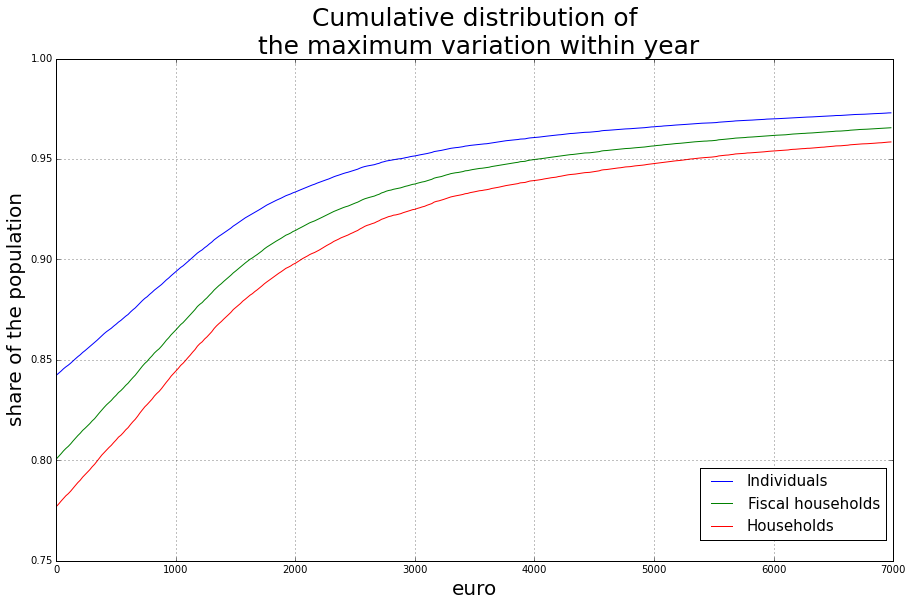

In [36]:

plt.figure(figsize=(15,9))
plt.plot(range_to_use,income_rep_func,label = 'Individuals')
plt.plot(range_to_use,income_rep_func_f,label = 'Fiscal households')
plt.plot(range_to_use,income_rep_func_m,label = 'Households')


plt.ylabel("share of the population", fontsize=20 )
plt.xlabel("euro", fontsize=20)
plt.title('Cumulative distribution of \n the maximum variation within year', fontsize = 25)

plt.legend(bbox_to_anchor=(1, 0.2), fontsize=15)
plt.grid()
plt.figure(figsize = (10,20))

In [37]:
count,division = np.histogram(df[(df.yearly_income>0)].yearly_income,bins=10)
bins = df[(df.yearly_income>0)&(df.yearly_income<175000)].yearly_income.quantile(np.arange(0,1.1,0.1))

In [38]:
#### Marginal rates
from openfisca_utils import make_ready_to_use_simulation
from openfisca_core import rates
test_case_simulation = make_ready_to_use_simulation.make_ready_to_use_simulation(2009,False)
rbg_test_case = test_case_simulation.calculate('rbg')
irpp_test_case = test_case_simulation.calculate('irpp')
revdisp_test_case = test_case_simulation.calculate('revdisp')
marginal_rate = rates.marginal_rate(irpp_test_case, rbg_test_case)-1
global_marginal_rate = rates.marginal_rate(revdisp_test_case, rbg_test_case)
to_change = pd.Series(marginal_rate)[marginal_rate>1].index
#to_change = pd.Series(rates.marginal_rate(irpp_test_case, rbg_test_case)-1)[rates.marginal_rate(irpp_test_case, rbg_test_case)-1>1].index
marginal_rate[to_change] = marginal_rate[to_change+1]

#Average
global_average_rate = rates.average_rate(revdisp_test_case[76:] - revdisp_test_case[0], rbg_test_case[76:])
average_rate = rates.average_rate(irpp_test_case[76:] , rbg_test_case[76:])

In [39]:
rbg_test_case[:48]

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,  23.51681519,  80.56002808], dtype=float32)

(0, 50000)

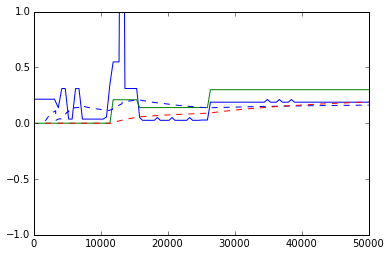

In [40]:
plt.plot( rbg_test_case[::10], global_marginal_rate[::10])
plt.plot(rbg_test_case[::10], marginal_rate[::10])
plt.plot(rbg_test_case[76:], global_average_rate, '--b')
plt.plot(rbg_test_case[76:], average_rate-1, '--r')
plt.ylim(-1,1)
plt.xlim(0,50000)

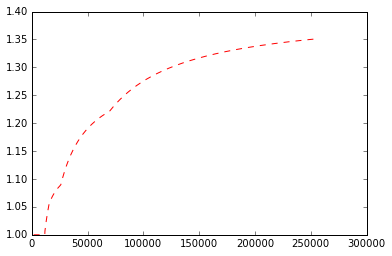

In [41]:
plt.plot(rbg_test_case[76:], average_rate, '--r')

In [42]:
survey_scenario.simulation.calculate("rbg")

array([ 24949.00195312,   4340.        ,      0.        , ...,
         4699.        ,     98.        ,      0.        ], dtype=float32)

In [43]:
income_by_fisal_shares = (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))  
                                                           
df_m["income_by_fiscalshares"] =  switch_array_entity(income_by_fisal_shares,  "foyer_fiscal", "menage")  #income_by_fiscal_shares
df_f.shape
                                                                     
                              

(59874, 15)

(0, 20000)

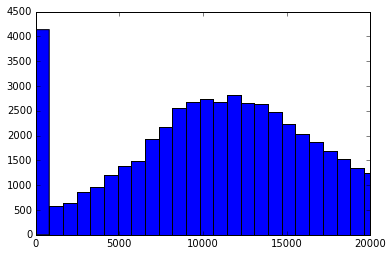

In [44]:
plt.hist(survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"), bins = 1000)
plt.xlim(0,20000)

(0, 1)

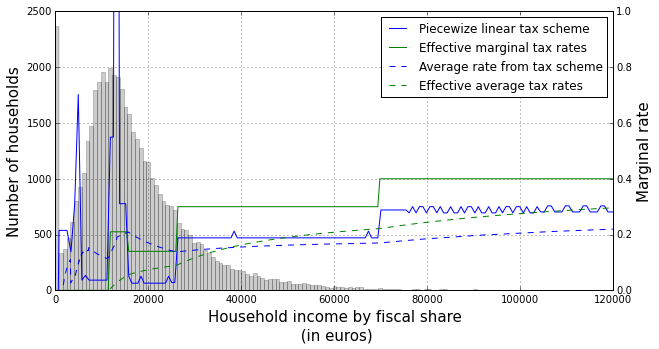

In [45]:
plt.figure(figsize=(10,5))
ax = df_m.income_by_fiscalshares.hist(bins =1000, alpha = 0.2, color = 'k')

ax2 = ax.twinx()
#ax2.plot( rbg_test_case[::35], global_marginal_rate[::35])
ax2.plot( rbg_test_case[::15], global_marginal_rate[::15], '-b',label = "Piecewize linear tax scheme")
ax2.plot(rbg_test_case[::10], marginal_rate[::10],  '-g',label = "Effective marginal tax rates")
ax2.plot(rbg_test_case[76:], global_average_rate, '--b', label = "Average rate from tax scheme")
ax2.plot(rbg_test_case[76:], average_rate-1, '--g', label = "Effective average tax rates")
ax2.legend(loc = 1)
plt.xlim(0,120000)
ax.set_ylabel('Number of households', fontsize=15)
ax.set_xlabel('Household income by fiscal share \n (in euros)', fontsize=15)
ax2.set_ylabel('Marginal rate', fontsize=15)
ax2.set_ylim(0,1)

In [46]:
simulation.calculate('rbg_mensuel_times_12', '2009-01')

array([ 25250.66601562,   5786.33300781,      0.        , ...,
            0.        ,     98.        ,      0.        ], dtype=float32)

In [47]:
rbg_month_by_fs_list = ["rbg_month_by_fs_{}".format(month) for month in range(1,13)]
df_m = pd.DataFrame()

for month in range(1,13):
    month_rbg = np.zeros(59874)
    for var in ['rni_mensuel_times_12']:
        month_rbg += (simulation.calculate(var,"2009-{}".format(month))/12)
    df_m["rbg_month_by_fs_{}".format(month)] = switch_array_entity(month_rbg, 'foyer_fiscal','menage')/switch_entity('nbptr', 'menage')
    

df_m["yearly_rbg_by_fs"] = df_m[rbg_month_by_fs_list].sum(1)
df_m["diff_rbg"] = df_m[rbg_month_by_fs_list].max(1) - df_m[rbg_month_by_fs_list].min(1)
df_m["rbg_relative_var"] = (df_m[rbg_month_by_fs_list].max(1) - df_m[rbg_month_by_fs_list].min(1))/df_m[rbg_month_by_fs_list].max(1)

has_rbg_filter_m = df_m["yearly_rbg_by_fs"]>1

range_to_use = range(1,7000,20)

In [48]:
rbg_month_by_fs_list = ["rbg_month_by_fs_{}".format(month) for month in range(1,13)]
df_f = pd.DataFrame()

for month in range(1,13):
    month_rbg = np.zeros(59874)
    for var in ['rni_mensuel_times_12']:
        month_rbg += (simulation.calculate(var,"2009-{}".format(month))/12)
    df_f["rbg_month_by_fs_{}".format(month)] = month_rbg/simulation.calculate("nbptr")
    

df_f["yearly_rbg_by_fs"] = df_m[rbg_month_by_fs_list].sum(1)
df_f["diff_rbg"] = df_m[rbg_month_by_fs_list].max(1) - df_m[rbg_month_by_fs_list].min(1)
df_f["rbg_relative_var"] = (df_m[rbg_month_by_fs_list].max(1) - df_m[rbg_month_by_fs_list].min(1))/df_m[rbg_month_by_fs_list].max(1)

has_rbg_filter_f = df_m["yearly_rbg_by_fs"]>1

range_to_use = range(1,7000,20)

In [49]:
switch_entity('nbptr', 'menage')

array([ 3.,  1.,  2., ...,  1.,  4.,  2.])

In [50]:
switch_array_entity(month_rbg, 'foyer_fiscal','menage').shape

(49016,)

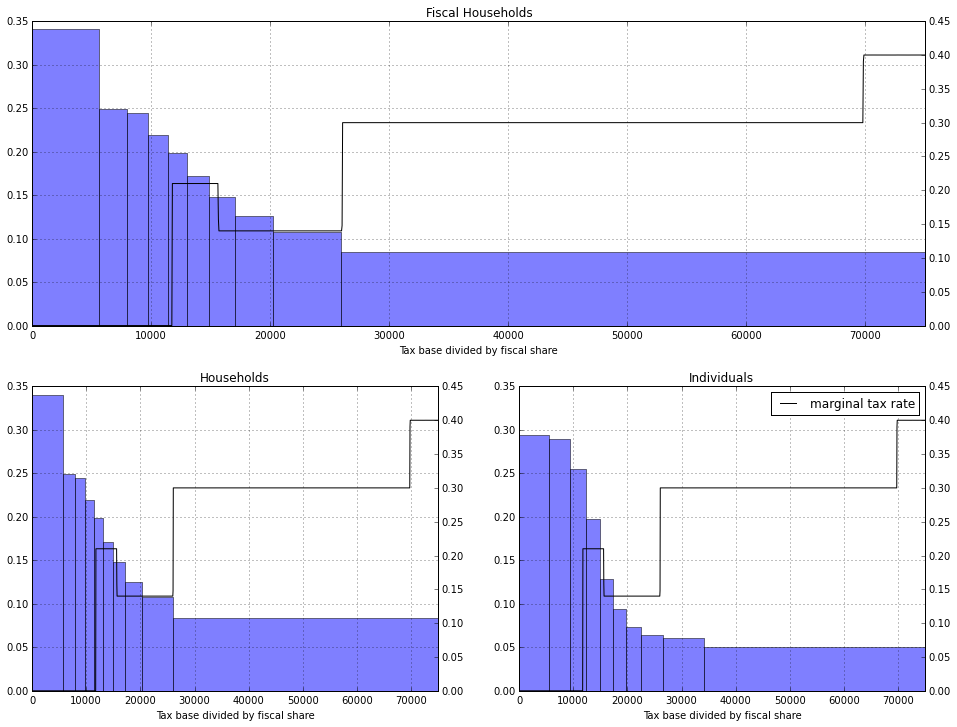

In [51]:



#TODO: vérifier que ça prend bien en compte les 10% d'abbatement, bref que rbg est bien la bonne base taxable à prendre en considération.

#(survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr")

fig = plt.figure(figsize=(16, 12))


ax1 = plt.subplot2grid((2,2), (1,0), colspan=1) ; plt.figure()

rev_max = 175000
bins_to_graph = df_m[(df_m.yearly_rbg_by_fs>0)&(df_m.yearly_rbg_by_fs<175000)].yearly_rbg_by_fs.quantile(np.arange(0,1.1,0.1))

n,bins,patches = plt.hist(df_m[((df_m.yearly_rbg_by_fs>0)&(df_m.yearly_rbg_by_fs<rev_max)) & 
                             (df_m.rbg_relative_var>0.2)].yearly_rbg_by_fs.values, 
                              bins= bins_to_graph.values
                         )
plt.close() #do not display first plots

plt.figure()
rev_max = 175000
bins_to_graph = df_m[(df_m.yearly_rbg_by_fs>0)&(df_m.yearly_rbg_by_fs<175000)].yearly_rbg_by_fs.quantile(np.arange(0,1.1,0.1))
n2,bins2,patches2 = plt.hist(df_m[((df_m.yearly_rbg_by_fs>0)&
                                 (df_m.yearly_rbg_by_fs<rev_max))].yearly_rbg_by_fs.values,
                             bins= bins_to_graph.values)
plt.close() #do not display first plots
width_list = []
for i in range(0,bins2.shape[0]-1):
    width_list.append(bins2[i]-bins2[i+1])
ax1.bar( bins2[1::], n/n2,width = width_list, alpha = 0.5)
ax1.grid()
ax1.set_xlim([0,100000])
ax1.set_title("Households")
ax1_2 = ax1.twinx()
ax1_2.plot(rbg_test_case[1:],marginal_rate, 'k', label = "marginal tax rate")
ax1.set_xlim(0,75000)

ax1.set_xlabel('Tax base divided by fiscal share')






ax2 = plt.subplot2grid((2,2), (0,0), colspan=2,  sharey=ax1)


plt.figure()
rev_max = 175000
bins_to_graph = df_f[(df_f.yearly_rbg_by_fs>0)&(df_f.yearly_rbg_by_fs<175000)].yearly_rbg_by_fs.quantile(np.arange(0,1.1,0.1))
n,bins,patches = plt.hist(df_f[((df_f.yearly_rbg_by_fs>0)&(df_f.yearly_rbg_by_fs<rev_max)) & 
                             (df_f.rbg_relative_var>0.2)].yearly_rbg_by_fs.values, 
                              bins= bins_to_graph.values
                         )
plt.close() #do not display first plots

plt.figure()
rev_max = 175000
bins_to_graph = df_f[(df_f.yearly_rbg_by_fs>0)&(df_f.yearly_rbg_by_fs<175000)].yearly_rbg_by_fs.quantile(np.arange(0,1.1,0.1))
n2,bins2,patches2 = plt.hist(df_f[((df_f.yearly_rbg_by_fs>0)&
                                 (df_f.yearly_rbg_by_fs<rev_max))].yearly_rbg_by_fs.values,
                             bins= bins_to_graph.values)
plt.close() #do not display first plots
width_list = []
for i in range(0,bins2.shape[0]-1):
    width_list.append(bins2[i]-bins2[i+1])
ax2.bar( bins2[1::], n/n2,width = width_list, alpha = 0.5)
ax2.grid()
ax2_2 = ax2.twinx()
ax2_2.plot(rbg_test_case[1:],marginal_rate, 'k', label = "Marginal tax rate")

ax2.set_xlim([0,75000])
ax2.set_title("Fiscal Households")
ax2.set_xlabel('Tax base divided by fiscal share')




ax3 = plt.subplot2grid((2,2), (1,1), colspan=1, sharey=ax1)
plt.figure()
rev_max = 175000
bins_to_graph = df[(df.yearly_income>0)&(df.yearly_income<175000)].yearly_income.quantile(np.arange(0,1.1,0.1))
n,bins,patches = plt.hist(df[((df.yearly_income>0)&(df.yearly_income<rev_max)) & 
                             (df.relative_var>0.2)].yearly_income.values, 
                              bins= bins_to_graph.values
                         )
plt.close() #do not display first plots

plt.figure()
rev_max = 175000
bins_to_graph = df[(df.yearly_income>0)&(df.yearly_income<175000)].yearly_income.quantile(np.arange(0,1.1,0.1))
n2,bins2,patches2 = plt.hist(df[((df.yearly_income>0)&
                                 (df.yearly_income<rev_max))].yearly_income.values,
                             bins= bins_to_graph.values)
plt.close() #do not display first plots
width_list = []
for i in range(0,bins2.shape[0]-1):
    width_list.append(bins2[i]-bins2[i+1])
ax3.bar( bins2[1::], n/n2,width = width_list, alpha = 0.5)
ax3.grid()
ax3_2 = ax3.twinx()
ax3_2.plot(rbg_test_case[1:],marginal_rate, 'k', label = "marginal tax rate")
ax3_2.legend()

ax3.set_xlim([0,75000])
ax3.set_title("Individuals")
ax3.set_xlabel('Tax base divided by fiscal share')

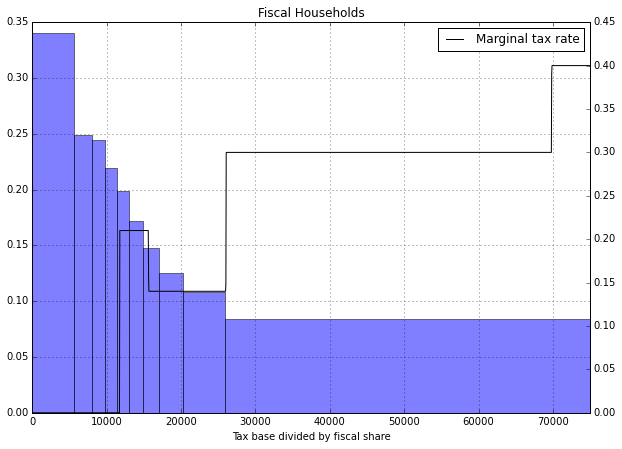

In [52]:



#TODO: vérifier que ça prend bien en compte les 10% d'abbatement, bref que rbg est bien la bonne base taxable à prendre en considération.

#(survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr")

fig = plt.figure(figsize=(10, 7))








ax2 = plt.subplot2grid((1,1), (0,0), colspan=2)


plt.figure()
rev_max = 175000
bins_to_graph = df_f[(df_f.yearly_rbg_by_fs>0)&(df_f.yearly_rbg_by_fs<175000)].yearly_rbg_by_fs.quantile(np.arange(0,1.1,0.1))
n,bins,patches = plt.hist(df_f[((df_f.yearly_rbg_by_fs>0)&(df_f.yearly_rbg_by_fs<rev_max)) & 
                             (df_f.rbg_relative_var>0.2)].yearly_rbg_by_fs.values, 
                              bins= bins_to_graph.values
                         )
plt.close() #do not display first plots

plt.figure()
rev_max = 175000
bins_to_graph = df_f[(df_f.yearly_rbg_by_fs>0)&(df_f.yearly_rbg_by_fs<175000)].yearly_rbg_by_fs.quantile(np.arange(0,1.1,0.1))
n2,bins2,patches2 = plt.hist(df_f[((df_f.yearly_rbg_by_fs>0)&
                                 (df_f.yearly_rbg_by_fs<rev_max))].yearly_rbg_by_fs.values,
                             bins= bins_to_graph.values)
plt.close() #do not display first plots
width_list = []
for i in range(0,bins2.shape[0]-1):
    width_list.append(bins2[i]-bins2[i+1])
ax2.bar( bins2[1::], n/n2,width = width_list, alpha = 0.5)
ax2.grid()
ax2_2 = ax2.twinx()
ax2_2.plot(rbg_test_case[1:],marginal_rate, 'k', label = "Marginal tax rate")

ax2.set_xlim([0,75000])
ax2.set_title("Fiscal Households")
ax2.set_xlabel('Tax base divided by fiscal share')
ax2_2.legend()




### Reforme

/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


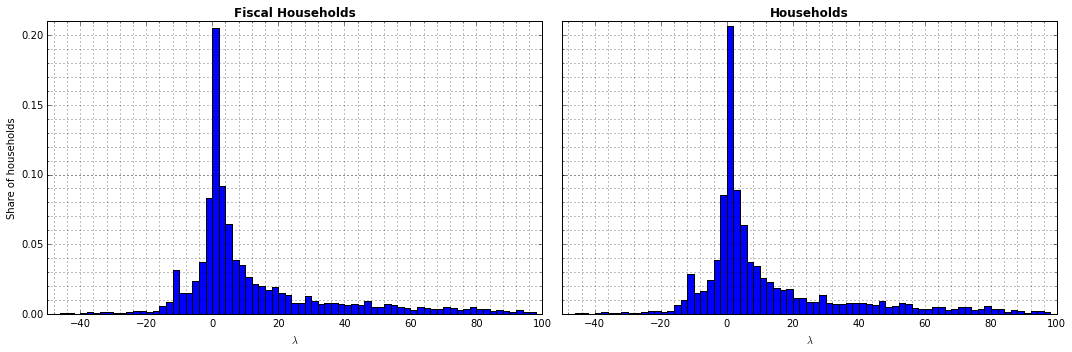

In [53]:
nb_minor_ticks = 5


weights = weight_foyers/sum(weight_foyers)

bins= range(-100,100, 2)

lambda_compensation = survey_scenario.simulation.calculate("lambda_compensation", period.this_year)
lambda_compensation_household = switch_array_entity(lambda_compensation,'foyer_fiscal', 'menage')
graph_filter = (np.abs(lambda_compensation)>.1)&(np.abs(lambda_compensation)<100)
graph_filter_household = switch_array_entity(graph_filter, 'foyer_fiscal', 'menage').astype('bool')

fig, ax = plt.subplots(1,2,sharey = True, figsize = (15, 5), tight_layout = True)


ax[0].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[0].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))

ax[1].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[1].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))


weights = weight_foyers[graph_filter]/sum(weight_foyers[graph_filter])
ax[0].hist(lambda_compensation[graph_filter], bins = bins, weights = weights)
ax[0].set_ylim(0,0.21)
ax[0].set_xlim(-50,100)
ax[0].set_title("Fiscal Households", weight = "bold")
ax[0].set_ylabel('Share of households')
ax[0].set_xlabel('$\lambda$')
ax[0].grid(which = 'both')
ax[1].grid(which = 'both')


weights = weight_menages[graph_filter_household & ~np.isnan(lambda_compensation_household)]/sum(weight_menages[graph_filter_household& ~np.isnan(lambda_compensation_household)])
ax[1].hist(pd.Series(lambda_compensation_household[graph_filter_household]).dropna(), bins = bins, weights= weights)
ax[1].set_xlim(-50,100)

ax[1].set_xlabel('$\lambda$')
ax[1].set_title("Households", weight = "bold")



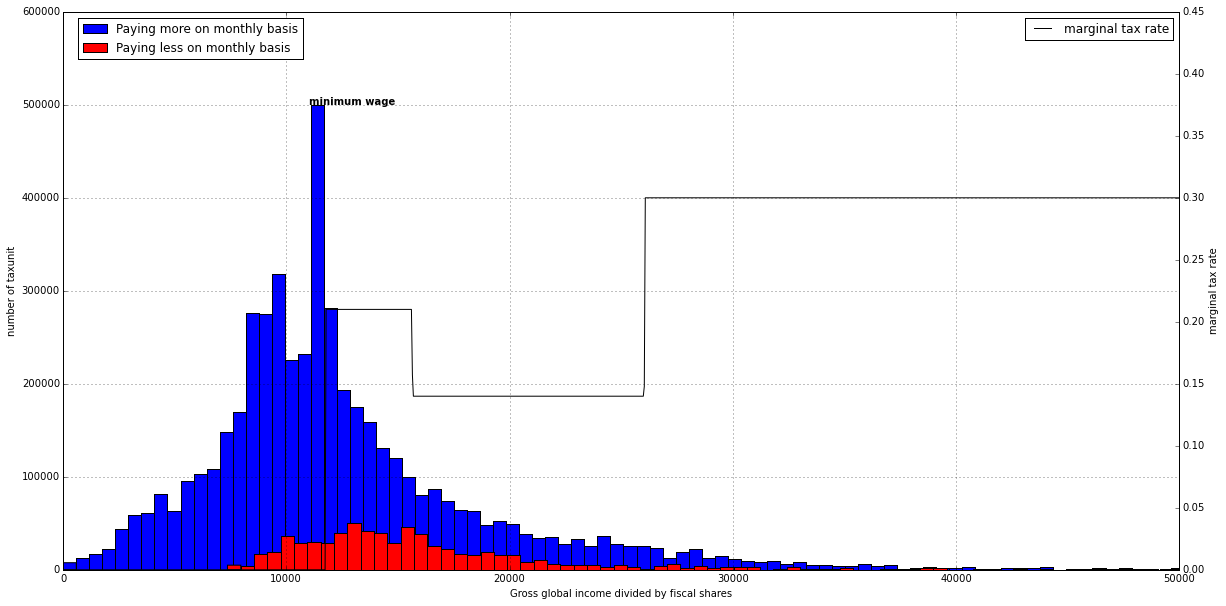

In [54]:


weights1 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")>1]
weights2 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")<-1]

fig, ax1 = plt.subplots(figsize=(20, 10))


ax1.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))>1], bins = 400, label = "Paying more on monthly basis", 
         weights= weights1)
ax1.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))<-1], bins = 130, color= 'r', label = "Paying less on monthly basis",
         weights= weights2)


ax1.set_xlim(0,50000)
ax2 = plt.twinx()
ax2.plot(rbg_test_case[1:],marginal_rate, 'k', label = "marginal tax rate")
ax2.set_xlim(0,50000)
ax2.legend()
ax1.legend(bbox_to_anchor=(0.22, 1))
ax1.grid(which = 'both')
ax1.text(11000,500000, u"minimum wage", weight = 'bold',)
ax2.set_ylabel("marginal tax rate")
ax1.set_xlabel("Gross global income divided by fiscal shares")
ax1.set_ylabel("number of taxunit")
ax1.set_title("")


In [55]:
winners_condition = [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))>1]
winners = (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))[winners_condition]

loosers_condition = [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))<-1]
loosers = (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))[loosers_condition]


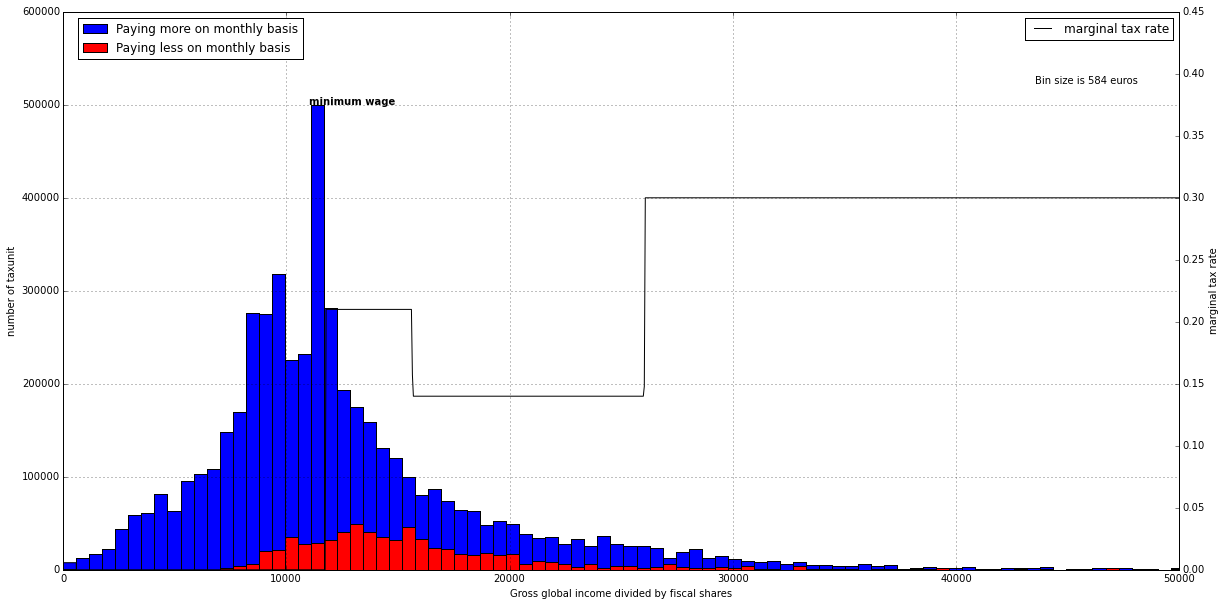

In [56]:

###One euro
weights1 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")>1]
weights2 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")<-1]

fig, ax1 = plt.subplots(figsize=(20, 10))


bins = np.histogram(np.hstack((winners,loosers)), bins = 400)[1]

ax1.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))>1], bins = bins, label = "Paying more on monthly basis", weights= weights1)
ax1.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))<-1], bins = bins, color= 'r', label = "Paying less on monthly basis",weights= weights2)


ax1.set_xlim(0,50000)
ax2 = plt.twinx()
ax2.plot(rbg_test_case[1:],marginal_rate, 'k', label = "marginal tax rate")
ax2.set_xlim(0,50000)
ax2.legend()
ax1.legend(bbox_to_anchor=(0.22, 1))
ax1.grid(which = 'both')
ax1.text(11000,500000, u"minimum wage", weight = 'bold',)
ax2.set_ylabel("marginal tax rate")
ax1.set_xlabel("Gross global income divided by fiscal shares")
ax1.set_ylabel("number of taxunit")
ax1.set_title("")
fig.text(0.8,0.8,'Bin size is {} euros'.format(np.rint((bins[1:] - bins[:-1])).astype('int')[0]))

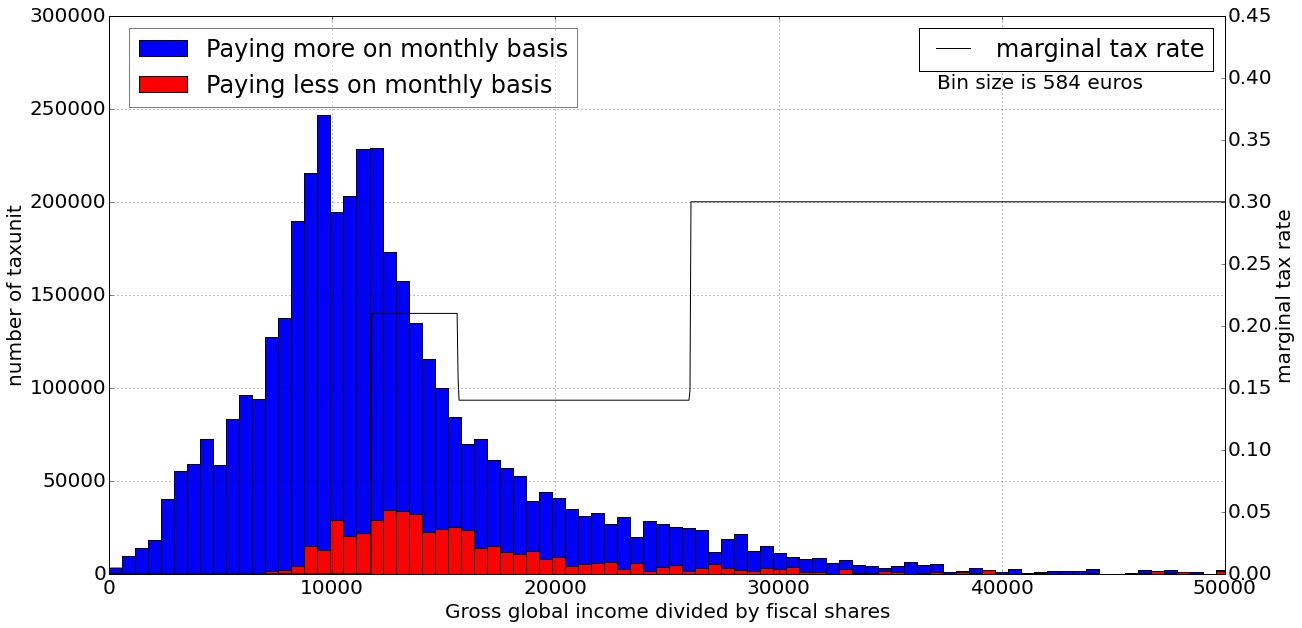

In [57]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
#50 euros
weights1 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")>50]
weights2 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")<-50]

fig, ax1 = plt.subplots(figsize=(20, 10))


bins = np.histogram(np.hstack((winners,loosers)), bins = 400)[1]

ax1.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))>50], bins = bins, label = "Paying more on monthly basis", weights= weights1)
ax1.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))<-50], bins = bins, color= 'r', label = "Paying less on monthly basis",weights= weights2)


ax1.set_xlim(0,50000)
ax2 = plt.twinx()
ax2.plot(rbg_test_case[1:],marginal_rate, 'k', label = "marginal tax rate")
ax2.set_xlim(0,50000)
ax2.legend()
legend = ax1.legend(bbox_to_anchor=(0.43, 1))
ax1.grid(which = 'both')
#ax1.text(11000,500000, u"minimum wage", weight = 'bold',)
ax2.set_ylabel("marginal tax rate")
ax1.set_xlabel("Gross global income divided by fiscal shares")
ax1.set_ylabel("number of taxunit")
ax1.set_title("")
legend.get_frame().set_alpha(0.5)
ax1.set_ylim(0,300000)
fig.text(0.7,0.8,'Bin size is {} euros'.format(np.rint((bins[1:] - bins[:-1])).astype('int')[0]))

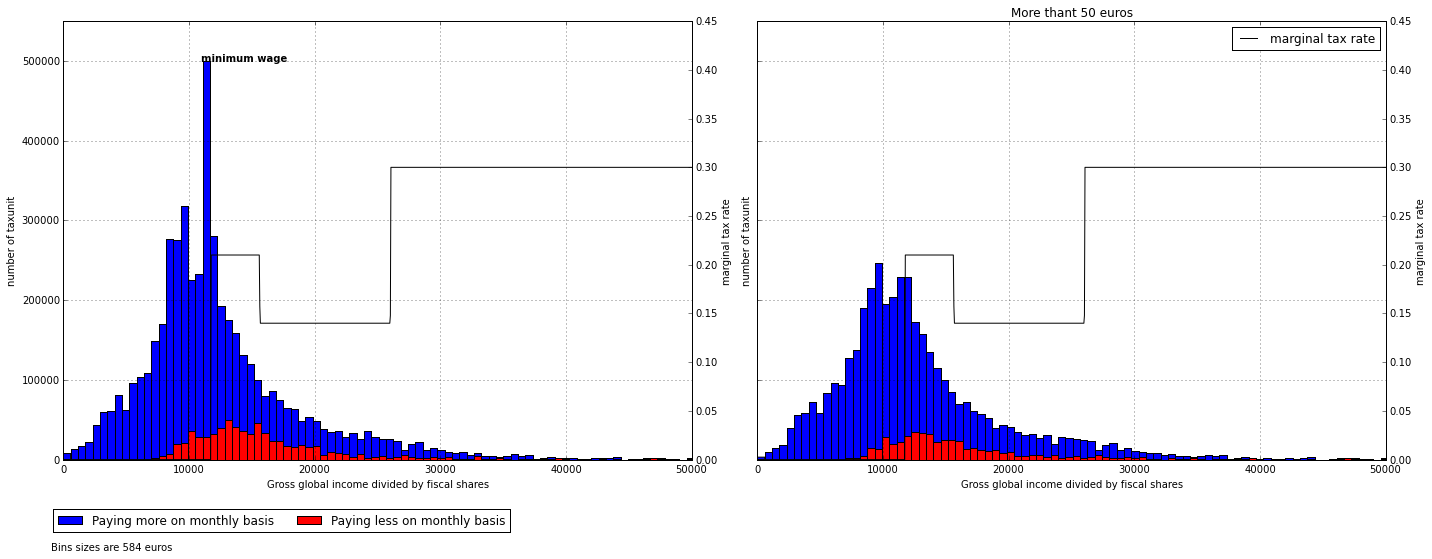

In [58]:
matplotlib.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(1,2,sharey = True, figsize = (20, 7), tight_layout = True)


###One euro
weights1 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")>1]
weights2 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")<-1]


bins = np.histogram(np.hstack((winners,loosers)), bins = 400)[1]

hist_1 = ax[0].hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))>1], bins = bins, label = "Paying more on monthly basis", weights= weights1)
hist_2 = ax[0].hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))<-1], bins = bins, color= 'r', label = "Paying less on monthly basis",weights= weights2)


ax[0].set_xlim(0,50000)
ax2 = ax[0].twinx()
ax2.plot(rbg_test_case[1:],marginal_rate, 'k', label = "marginal tax rate")
ax2.set_xlim(0,50000)
#ax2.legend()

ax[0].grid(which = 'both')
ax[0].text(11000,500000, u"minimum wage", weight = 'bold',)
ax2.set_ylabel("marginal tax rate")
ax[0].set_xlabel("Gross global income divided by fiscal shares")
ax[0].set_ylabel("number of taxunit")
ax[0].set_title("")
#fig.text(0.8,0.8,'Bin size is {} euros'.format(np.rint((bins[1:] - bins[:-1])).astype('int')[0]))

#50 euros
weights1 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")>50]
weights2 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")<-50]



bins = np.histogram(np.hstack((winners,loosers)), bins = 400)[1]

ax[1].hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))>50], bins = bins, label = "Paying more on monthly basis", weights= weights1)
ax[1].hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))<-50], bins = bins, color= 'r', label = "Paying less on monthly basis",weights= weights2)


ax[1].set_xlim(0,50000)
ax2 = ax[1].twinx()
ax2.plot(rbg_test_case[1:],marginal_rate, 'k', label = "marginal tax rate")
ax2.set_xlim(0,50000)
ax2.legend()
#legend = ax[1].legend(bbox_to_anchor=(0.22, 1))
ax[1].grid(which = 'both')
#ax1.text(11000,500000, u"minimum wage", weight = 'bold',)
ax2.set_ylabel("marginal tax rate")
ax[1].set_xlabel("Gross global income divided by fiscal shares")
ax[1].set_ylabel("number of taxunit")
ax[1].set_title("More thant 50 euros")
legend.get_frame().set_alpha(0.5)
ax[1].set_ylim(0,550000)

ax[0].legend(bbox_to_anchor=(0.72, -0.1), ncol = 3)
fig.text(0.038,-0.1,'Bins sizes are {} euros'.format(np.rint((bins[1:] - bins[:-1])).astype('int')[0]))
#fig.text(.38,-0.05,'Bins sizes are {} euros'.format(np.rint((bins[1:] - bins[:-1])).astype('int')[0]))

##  Utility analysis

In [59]:
u_ir_m_rsa_m = pd.Series(survey_scenario.simulation.calculate_add('utility_ir_mensuel_rsa_mensuel','2009'))
u_c_ir = pd.Series(survey_scenario.simulation.calculate_add('utility_compensated_ir_mensuel','2009'))
u_ir_m = pd.Series(survey_scenario.simulation.calculate_add('utility_ir_mensuel','2009'))
u_ir_a = pd.Series(survey_scenario.simulation.calculate_add('utility_ir_annuel','2009'))
u_vickrey = pd.Series(survey_scenario.simulation.calculate_add('utility_ir_vickrey_mensuel','2009'))


2009-01
month:2008
2009-01:2
2009-01:3
2009-01:4
2009-01:5
2009-01:6
2009-01:7
2009-01:8
2009-01:9
2009-01:10
2009-01:11
month:2009


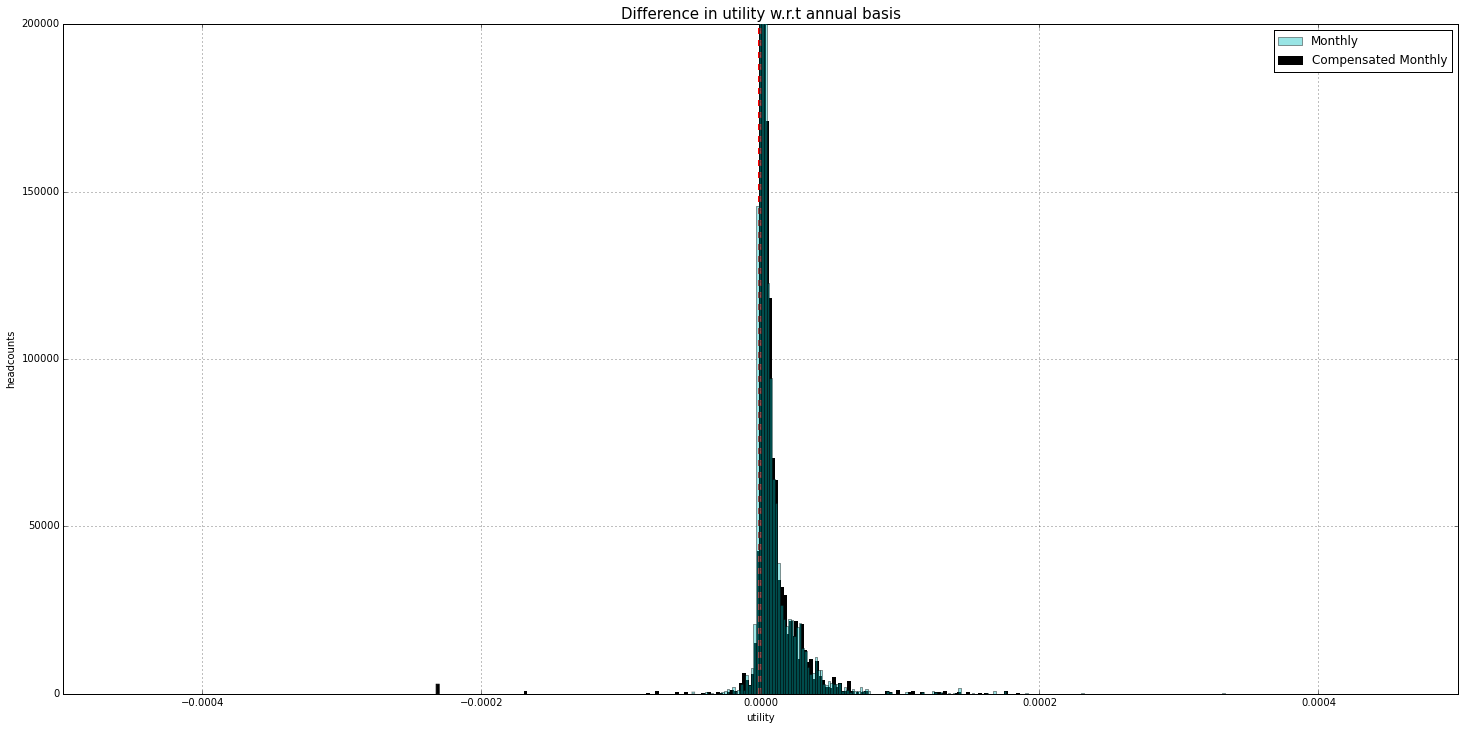

In [60]:
hist1 = ((u_ir_m - u_ir_a)).hist(bins = 200, figsize = (25,12), weights = weight_menages, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
hist2 = ((u_c_ir - u_ir_a)).hist(bins = 200, figsize = (25,12), weights = weight_menages,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
plt.ylim(0,20*10**4)
plt.xlim(-0.0005, 0.0005)
plt.legend()
plt.title("Difference in utility w.r.t annual basis", size = 15)
plt.xlabel('utility')
plt.ylabel('headcounts')

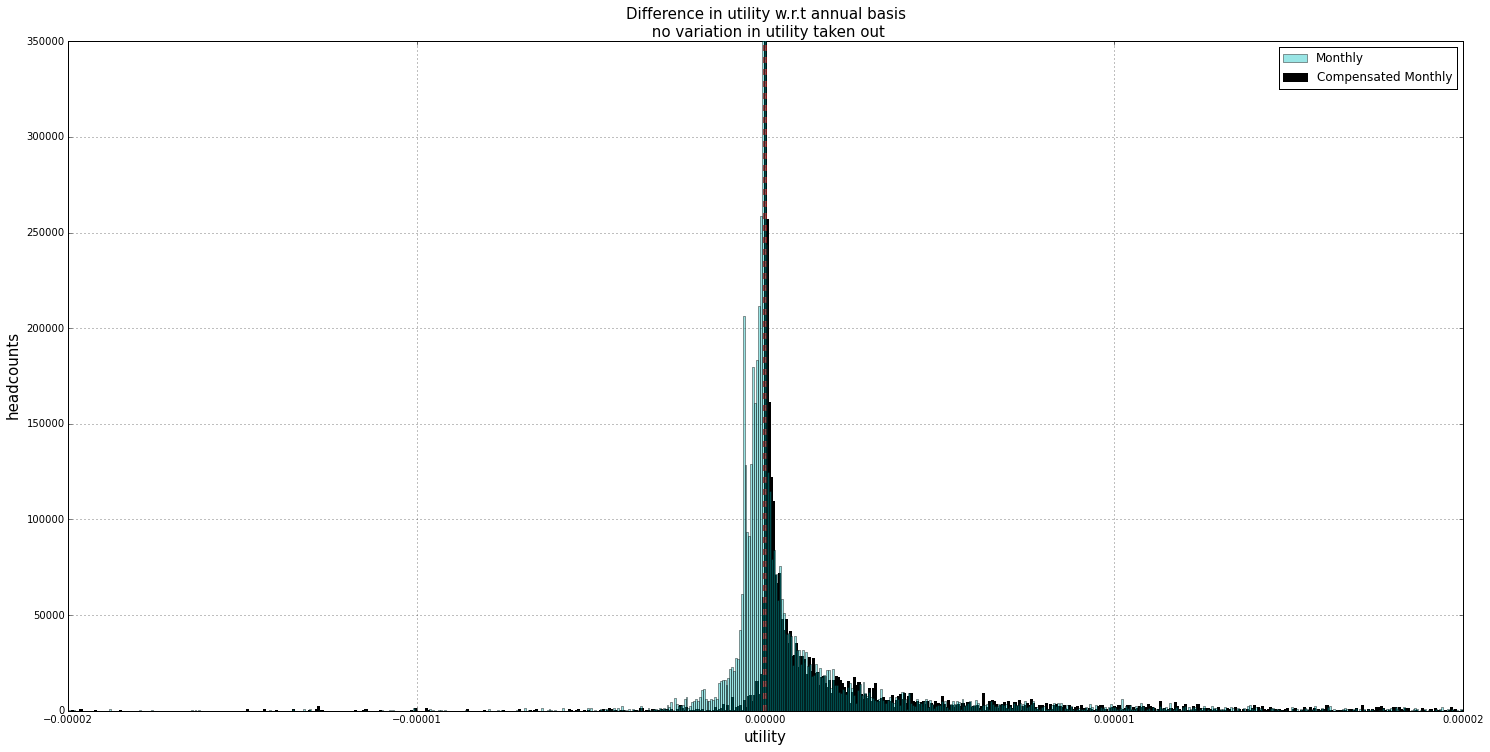

In [61]:
execute_time_consuming_graph = True
if execute_time_consuming_graph == True : 

    weight_1 = pd.Series(weight_menages)[((u_ir_m - u_ir_a))!=0].values
    weight_2 = pd.Series(weight_menages)[((u_c_ir - u_ir_a))!=0].values
    bins = np.histogram(np.hstack((weight_1,weight_2)), bins = 7000)[1]
    
    hist1 = ((u_ir_m - u_ir_a))[((u_ir_m - u_ir_a))!=0].hist(figsize = (25,12), bins=7000,
                                                             weights = weight_1, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_c_ir - u_ir_a))[((u_c_ir - u_ir_a))!=0].hist(figsize = (25,12), bins=7000,
                                                             weights = weight_2,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

    plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
    plt.ylim(0,35*10**4)
    plt.xlim(-0.00002, 0.00002)
    plt.legend()
    plt.title("Difference in utility w.r.t annual basis \n no variation in utility taken out", size = 15)
    plt.xlabel('utility', size = 15)
    plt.ylabel('headcounts', size = 15)

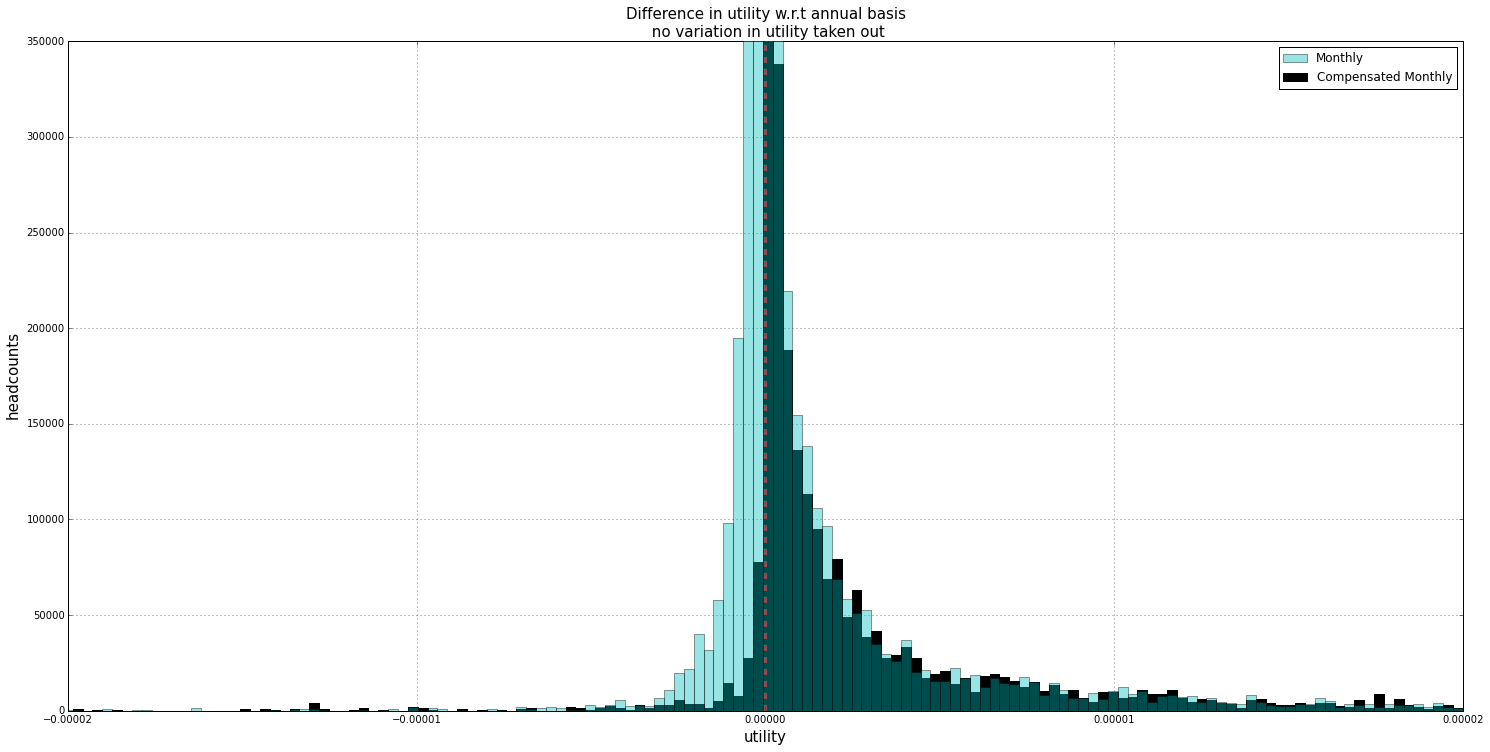

In [62]:
execute_time_consuming_graph = True
if execute_time_consuming_graph == True : 

    weight_1 = pd.Series(weight_menages)[((u_ir_m - u_ir_a))!=0].values
    weight_2 = pd.Series(weight_menages)[((u_c_ir - u_ir_a))!=0].values
    bins = np.histogram(np.hstack(((u_ir_m - u_ir_a)[((u_ir_m - u_ir_a))!=0]
                                    ,(u_c_ir - u_ir_a)[((u_c_ir - u_ir_a))!=0]
            )), bins = 2000)[1]
    
    hist1 = ((u_ir_m - u_ir_a))[((u_ir_m - u_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_1, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_c_ir - u_ir_a))[((u_c_ir - u_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_2,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

    plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
    plt.ylim(0,35*10**4)
    plt.xlim(-0.00002, 0.00002)
    plt.legend()
    plt.title("Difference in utility w.r.t annual basis \n no variation in utility taken out", size = 15)
    plt.xlabel('utility', size = 15)
    plt.ylabel('headcounts', size = 15)

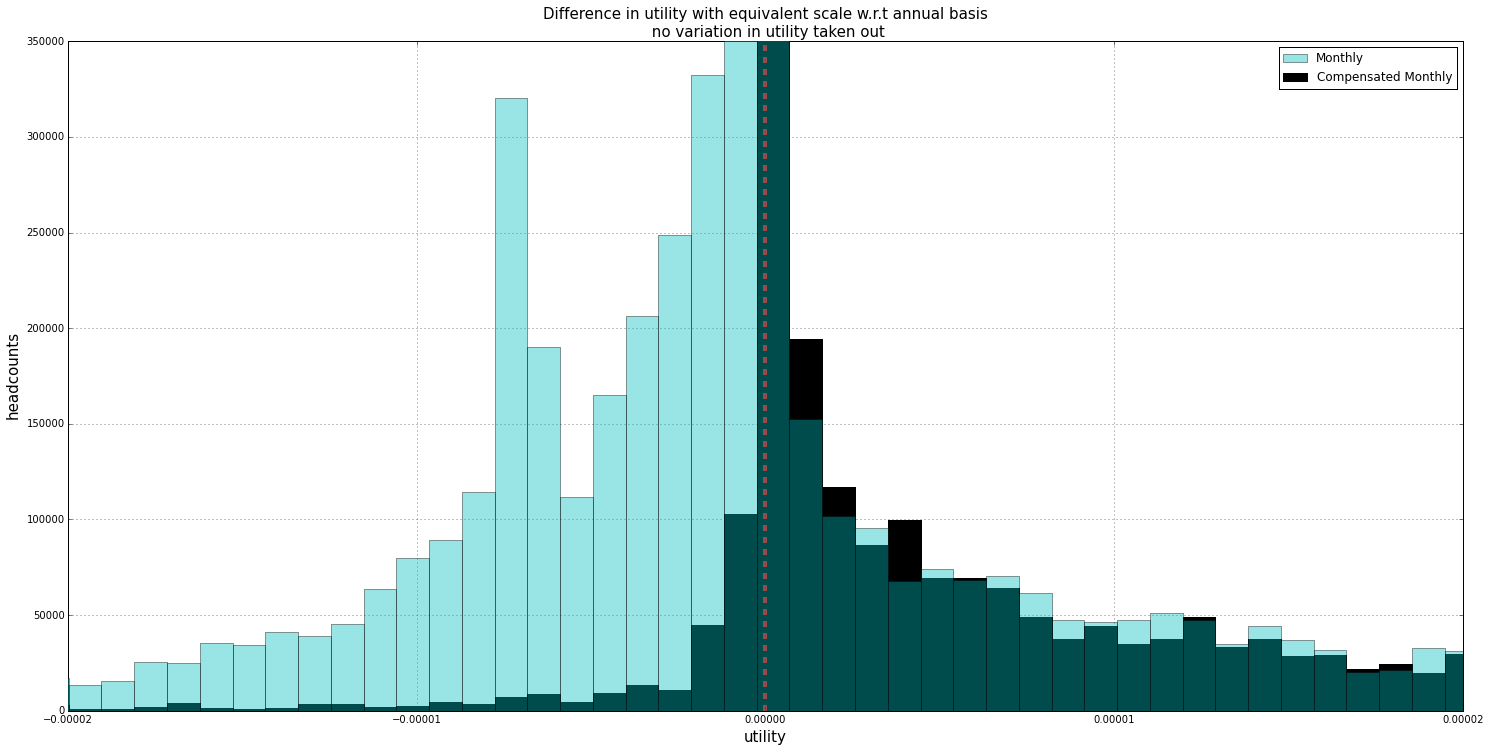

In [63]:
## Avec Echelles d'équivalences
#u_es_ir_m_rsa_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel_rsa_mensuel','2009'))
u_es_c_ir = pd.Series(survey_scenario.simulation.calculate_add('utility_es_compensated_ir_mensuel','2009'))
u_es_ir_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel','2009'))
u_es_ir_a = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_annuel','2009'))

execute_time_consuming_graph = True
if execute_time_consuming_graph == True : 

    weight_1 = pd.Series(weight_menages)[((u_es_ir_m - u_es_ir_a))!=0].values
    weight_2 = pd.Series(weight_menages)[((u_es_c_ir - u_es_ir_a))!=0].values
    bins = np.histogram(np.hstack(((u_es_ir_m - u_es_ir_a)[((u_es_ir_m - u_es_ir_a))!=0]
                                    ,(u_es_c_ir - u_es_ir_a)[((u_es_c_ir - u_es_ir_a))!=0]
            )), bins = 14000)[1]
    
    hist1 = ((u_es_ir_m - u_es_ir_a))[((u_es_ir_m - u_es_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_1, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_es_c_ir - u_es_ir_a))[((u_es_c_ir - u_es_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_2,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

    plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
    plt.ylim(0,35*10**4)
    plt.xlim(-0.00002, 0.00002)
    plt.legend()
    plt.title("Difference in utility with equivalent scale w.r.t annual basis \n no variation in utility taken out", size = 15)
    plt.xlabel('utility', size = 15)
    plt.ylabel('headcounts', size = 15)

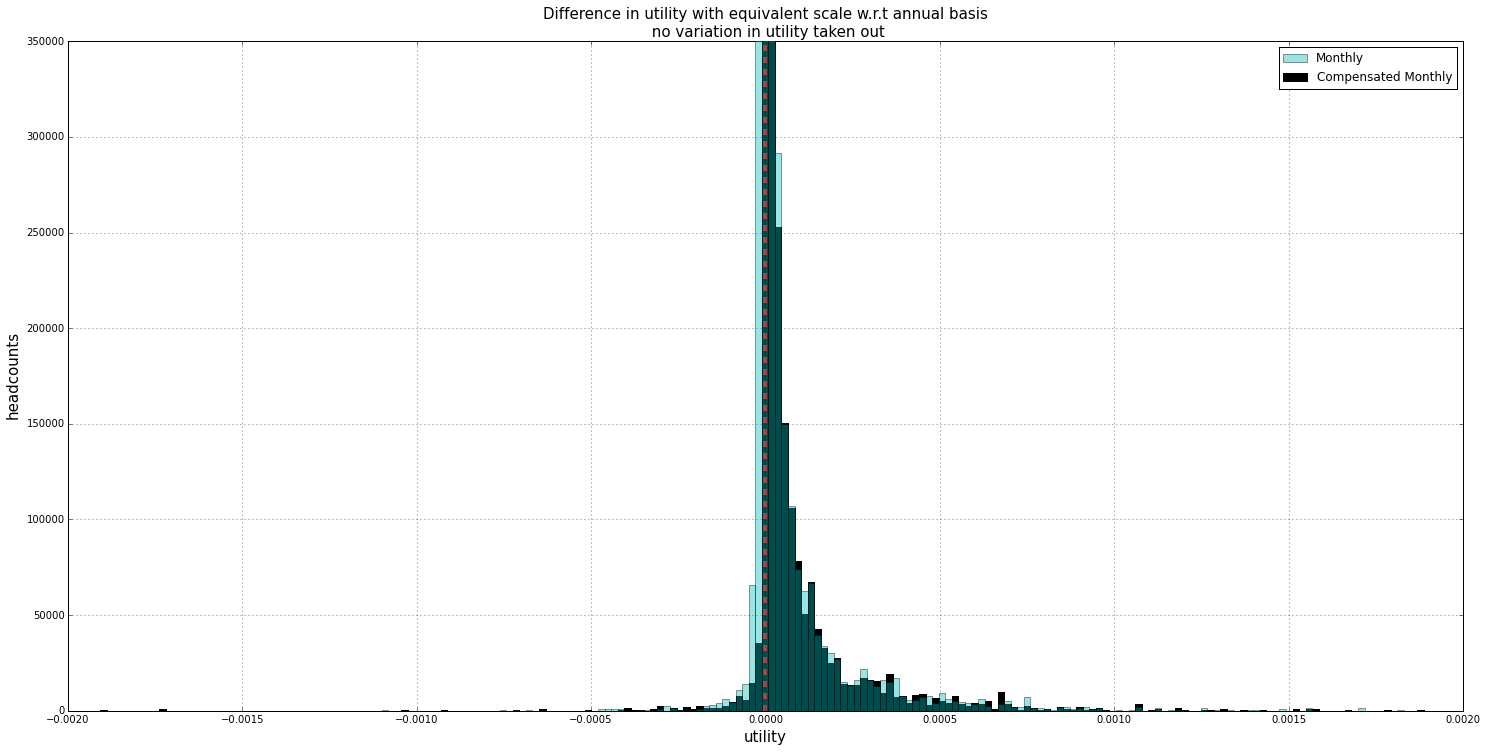

In [64]:
## Avec Echelles d'équivalences
#u_es_ir_m_rsa_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel_rsa_mensuel','2009'))
u_es_c_ir = pd.Series(survey_scenario.simulation.calculate_add('utility_es_compensated_ir_mensuel','2009'))
u_es_ir_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel','2009'))
u_es_ir_a = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_annuel','2009'))

execute_time_consuming_graph = True
if execute_time_consuming_graph == True : 

    weight_1 = pd.Series(weight_menages)[((u_es_ir_m - u_es_ir_a))!=0].values
    weight_2 = pd.Series(weight_menages)[((u_es_c_ir - u_es_ir_a))!=0].values
    bins = np.histogram(np.hstack(((u_es_ir_m - u_es_ir_a)[((u_es_ir_m - u_es_ir_a))!=0]
                                    ,(u_es_c_ir - u_es_ir_a)[((u_es_c_ir - u_es_ir_a))!=0]
            )), bins = 700)[1]
    
    hist1 = ((u_es_ir_m - u_es_ir_a))[((u_es_ir_m - u_es_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_1, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_es_c_ir - u_es_ir_a))[((u_es_c_ir - u_es_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_2,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

    plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
    plt.ylim(0,35*10**4)
    plt.xlim(-0.002, 0.002)
    plt.legend()
    plt.title("Difference in utility with equivalent scale w.r.t annual basis \n no variation in utility taken out", size = 15)
    plt.xlabel('utility', size = 15)
    plt.ylabel('headcounts', size = 15)

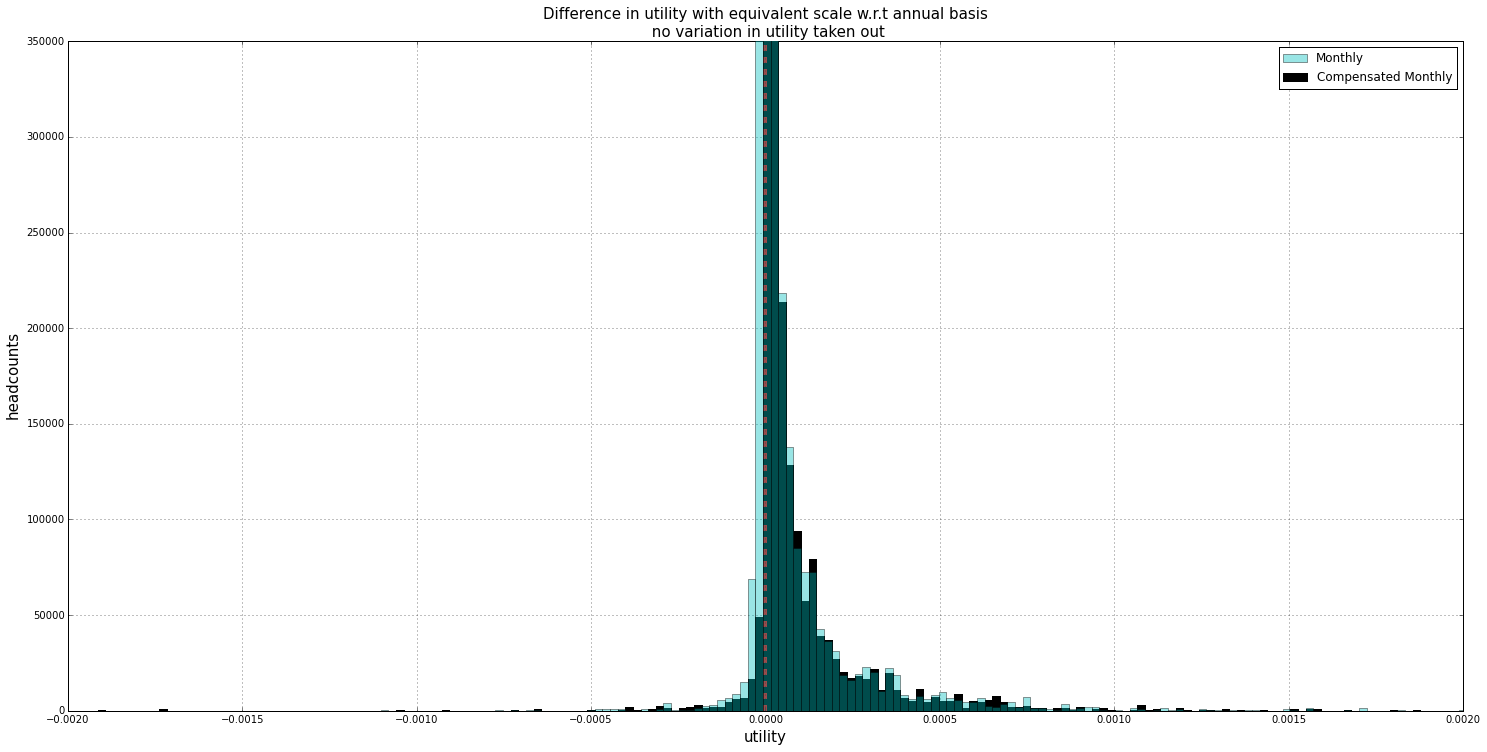

In [65]:
## Avec Echelles d'équivalences
#u_es_ir_m_rsa_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel_rsa_mensuel','2009'))
u_es_c_ir = pd.Series(survey_scenario.simulation.calculate_add('utility_es_compensated_ir_mensuel','2009'))
u_es_ir_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel','2009'))
u_es_ir_a = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_annuel','2009'))

execute_time_consuming_graph = True
if execute_time_consuming_graph == True : 

    value_near_zero = 0.0000009
    weight_1 = pd.Series(weight_menages)[(np.abs((u_es_ir_m - u_es_ir_a)))>value_near_zero].values
    weight_2 = pd.Series(weight_menages)[np.abs(u_es_c_ir - u_es_ir_a)> value_near_zero].values
    bins = np.histogram(np.hstack(((u_es_ir_m - u_es_ir_a)[(np.abs(u_es_ir_m - u_es_ir_a))>value_near_zero]
                                    ,(u_es_c_ir - u_es_ir_a)[np.abs((u_es_c_ir - u_es_ir_a))>value_near_zero]
            )), bins = 600)[1]
    
    hist1 = ((u_es_ir_m - u_es_ir_a))[(np.abs(u_es_ir_m - u_es_ir_a))>value_near_zero].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_1, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_es_c_ir - u_es_ir_a))[(np.abs(u_es_c_ir - u_es_ir_a))>value_near_zero].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_2,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

    plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
    plt.ylim(0,35*10**4)
    plt.xlim(-0.002, 0.002)
    plt.legend()    

    plt.title("Difference in utility with equivalent scale w.r.t annual basis \n no variation in utility taken out", size = 15)
    plt.xlabel('utility', size = 15)
    plt.ylabel('headcounts', size = 15)

##### Ce qui est fait pour le graph with equivalent scale : 
 - $u( \frac{\sum(y)}{ES})$ donne l'utilités d'un ménage, ou l'utilité moyenne des individus composant le ménage.
 - $u( \frac{\sum(y)}{ES})*ES $ donne l'utilité totale d'un ménage
 - et $u(\frac{\sum(y)}{ES})$ donnerait l'utilité d'un seul individu du ménage
 
###### Si on veut comparer une diff d'uilité entre deux système de taxe $u_1$ et $u_2$ : 
 - $u_1( \frac{\sum(y)}{ES}) * ES - u_2( \frac{\sum(y)}{ES}) *ES = ES [u_1( \frac{\sum(y)}{ES}) - u_2( \frac{\sum(y)}{ES})]  $ et créerai des écarts plus grand pour des ménages plus grands, alors que l'écart d'utilité moyenne serait la même.
 - Pour avoir une information individuelle, il faut prendre l'écart d'utilité pour chaque individus $u(\frac{\sum(y)}{ES})$ et multiplier le poids de l'observation par le nombre d'individus du ménage.


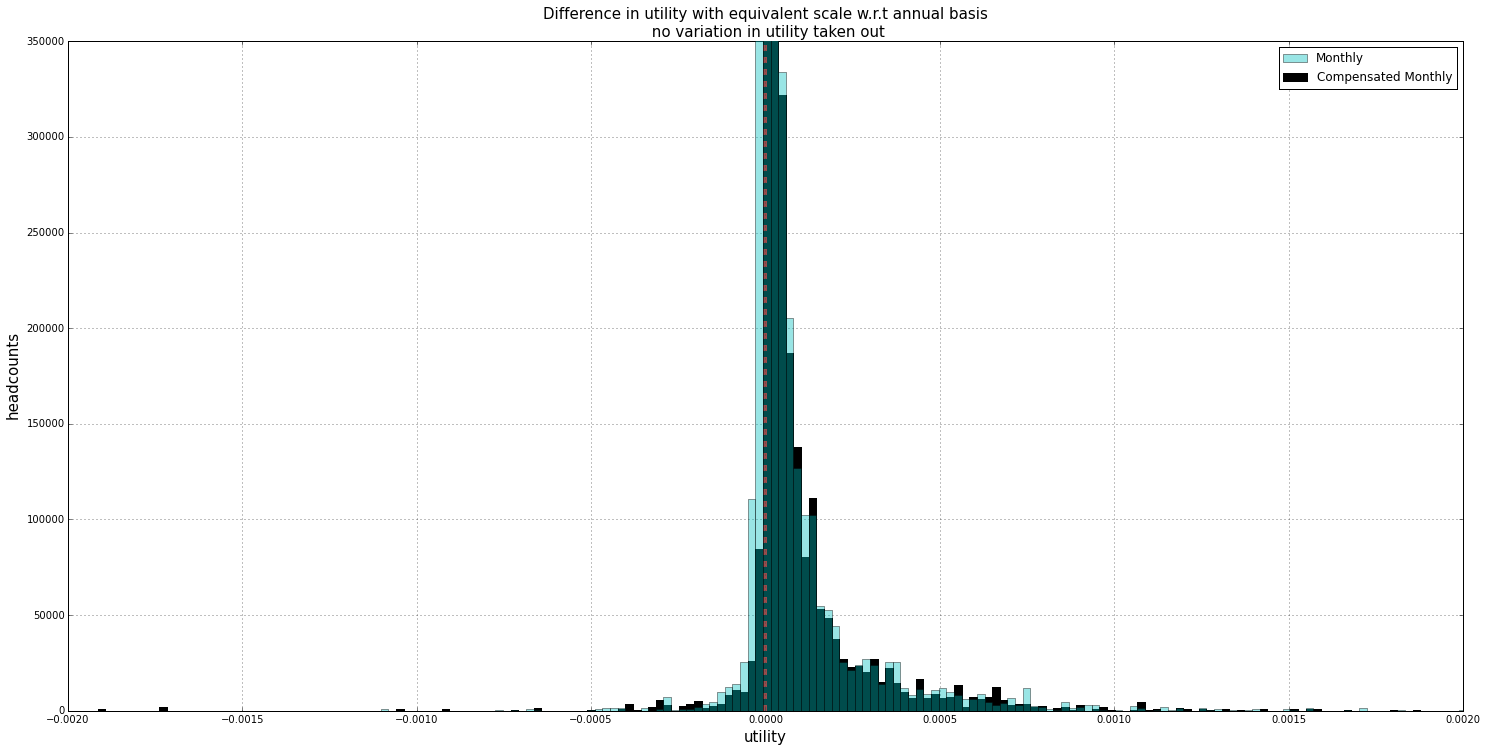

In [66]:
## Avec Echelles d'équivalences
#u_es_ir_m_rsa_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel_rsa_mensuel','2009'))
u_es_c_ir = pd.Series(survey_scenario.simulation.calculate_add('utility_es_compensated_ir_mensuel','2009'))
u_es_ir_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel','2009'))
u_es_ir_a = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_annuel','2009'))

execute_time_consuming_graph = True
if execute_time_consuming_graph == True : 

    value_near_zero = 0.0000009
    weight_1 = pd.Series(weight_menages*uc('menage'))[(np.abs((u_es_ir_m - u_es_ir_a)))>value_near_zero].values
    weight_2 = pd.Series(weight_menages*uc('menage'))[np.abs(u_es_c_ir - u_es_ir_a)> value_near_zero].values
    bins = np.histogram(np.hstack(((u_es_ir_m - u_es_ir_a)[(np.abs(u_es_ir_m - u_es_ir_a))>value_near_zero]
                                    ,(u_es_c_ir - u_es_ir_a)[np.abs((u_es_c_ir - u_es_ir_a))>value_near_zero]
            )), bins = 600)[1]
    
    hist1 = ((u_es_ir_m - u_es_ir_a))[(np.abs(u_es_ir_m - u_es_ir_a))>value_near_zero].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_1, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_es_c_ir - u_es_ir_a))[(np.abs(u_es_c_ir - u_es_ir_a))>value_near_zero].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_2,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

    plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
    plt.ylim(0,35*10**4)
    plt.xlim(-0.002, 0.002)
    plt.legend()    

    plt.title("Difference in utility with equivalent scale w.r.t annual basis \n no variation in utility taken out", size = 15)
    plt.xlabel('utility', size = 15)
    plt.ylabel('headcounts', size = 15)

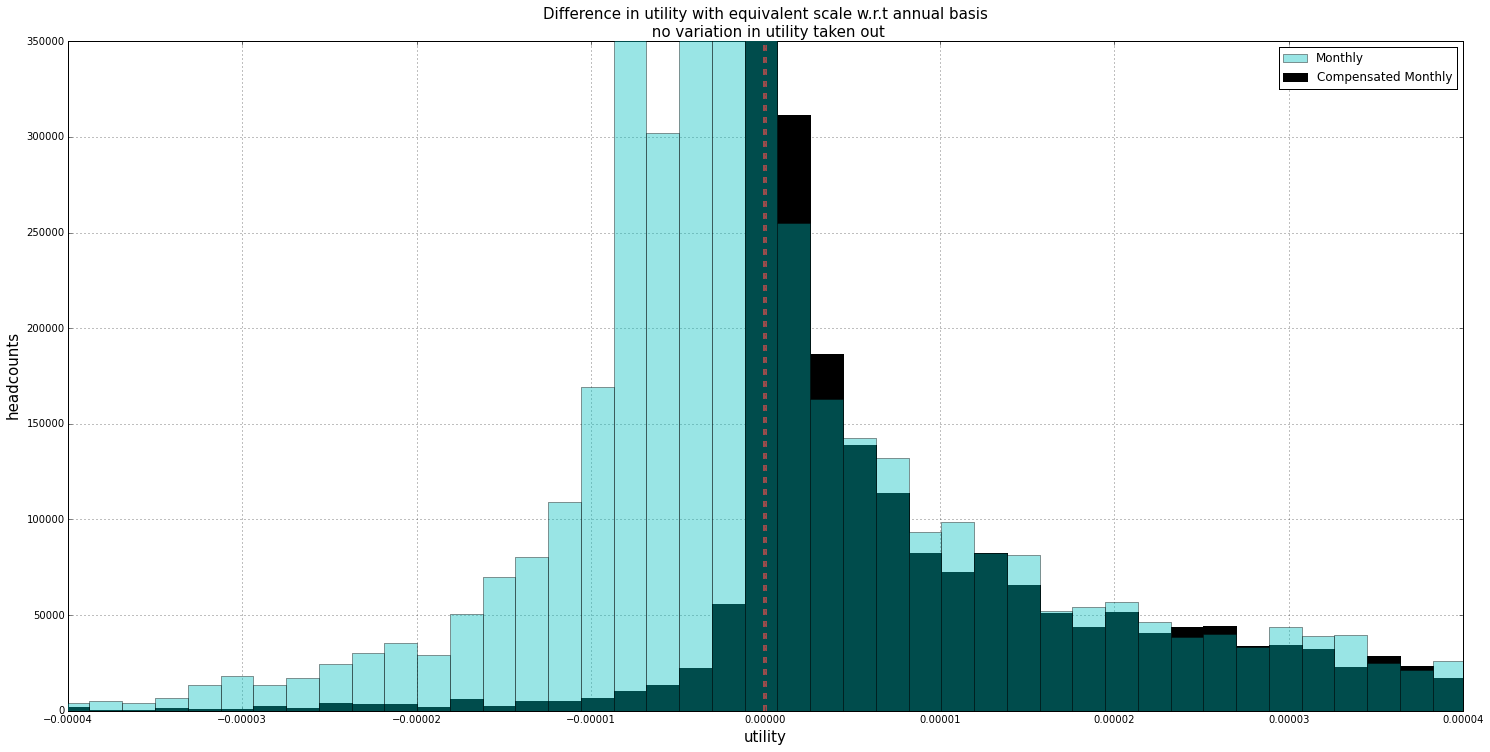

In [67]:
## Avec Echelles d'équivalences
#u_es_ir_m_rsa_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel_rsa_mensuel','2009'))
u_es_c_ir = pd.Series(survey_scenario.simulation.calculate_add('utility_es_compensated_ir_mensuel','2009'))
u_es_ir_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel','2009'))
u_es_ir_a = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_annuel','2009'))

execute_time_consuming_graph = True
if execute_time_consuming_graph == True : 

    weight_1 = pd.Series(weight_menages)[((u_es_ir_m - u_es_ir_a))!=0].values
    weight_2 = pd.Series(weight_menages)[((u_es_c_ir - u_es_ir_a))!=0].values
    bins = np.histogram(np.hstack(((u_es_ir_m - u_es_ir_a)[((u_es_ir_m - u_es_ir_a))!=0]
                                    ,(u_es_c_ir - u_es_ir_a)[((u_es_c_ir - u_es_ir_a))!=0]
            )), bins = 7000)[1]
    
    hist1 = ((u_es_ir_m - u_es_ir_a))[((u_es_ir_m - u_es_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_1, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_es_c_ir - u_es_ir_a))[((u_es_c_ir - u_es_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_2,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

    plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
    plt.ylim(0,35*10**4)
    plt.xlim(-0.00004, 0.00004)
    plt.legend()
    plt.title("Difference in utility with equivalent scale w.r.t annual basis \n no variation in utility taken out", size = 15)
    plt.xlabel('utility', size = 15)
    plt.ylabel('headcounts', size = 15)

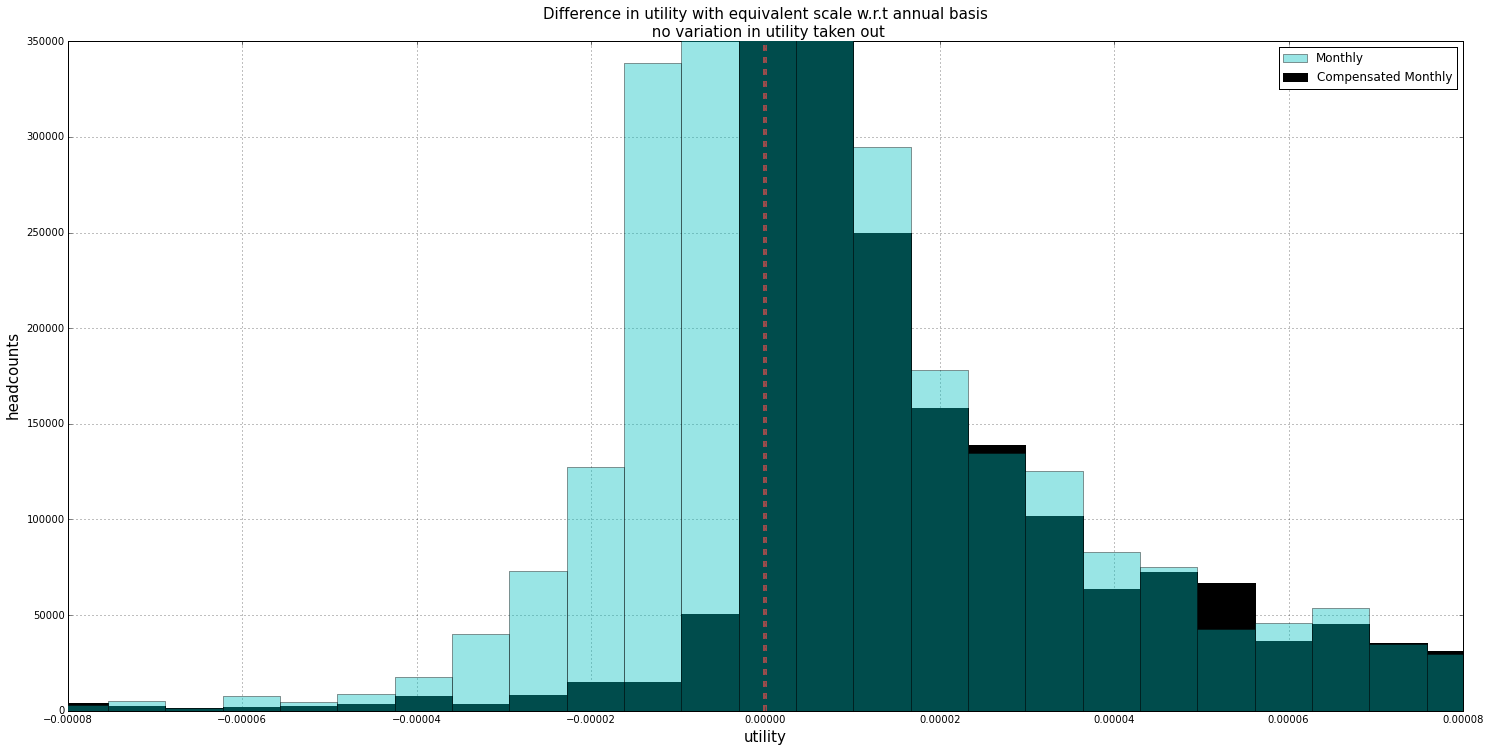

In [68]:
## Avec Echelles d'équivalences
#u_es_ir_m_rsa_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel_rsa_mensuel','2009'))
u_es_c_ir = pd.Series(survey_scenario.simulation.calculate_add('utility_es_compensated_ir_mensuel','2009'))
u_es_ir_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel','2009'))
u_es_ir_a = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_annuel','2009'))

execute_time_consuming_graph = True
if execute_time_consuming_graph == True : 

    weight_1 = pd.Series(weight_menages)[((u_es_ir_m - u_es_ir_a))!=0].values
    weight_2 = pd.Series(weight_menages)[((u_es_c_ir - u_es_ir_a))!=0].values
    bins = np.histogram(np.hstack(((u_es_ir_m - u_es_ir_a)[((u_es_ir_m - u_es_ir_a))!=0]
                                    ,(u_es_c_ir - u_es_ir_a)[((u_es_c_ir - u_es_ir_a))!=0]
            )), bins = 2000)[1]
    
    hist1 = ((u_es_ir_m - u_es_ir_a))[((u_es_ir_m - u_es_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_1, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_es_c_ir - u_es_ir_a))[((u_es_c_ir - u_es_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_2,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

    plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
    plt.ylim(0,35*10**4)
    plt.xlim(-0.00008, 0.00008)
    plt.legend()
    plt.title("Difference in utility with equivalent scale w.r.t annual basis \n no variation in utility taken out", size = 15)
    plt.xlabel('utility', size = 15)
    plt.ylabel('headcounts', size = 15)

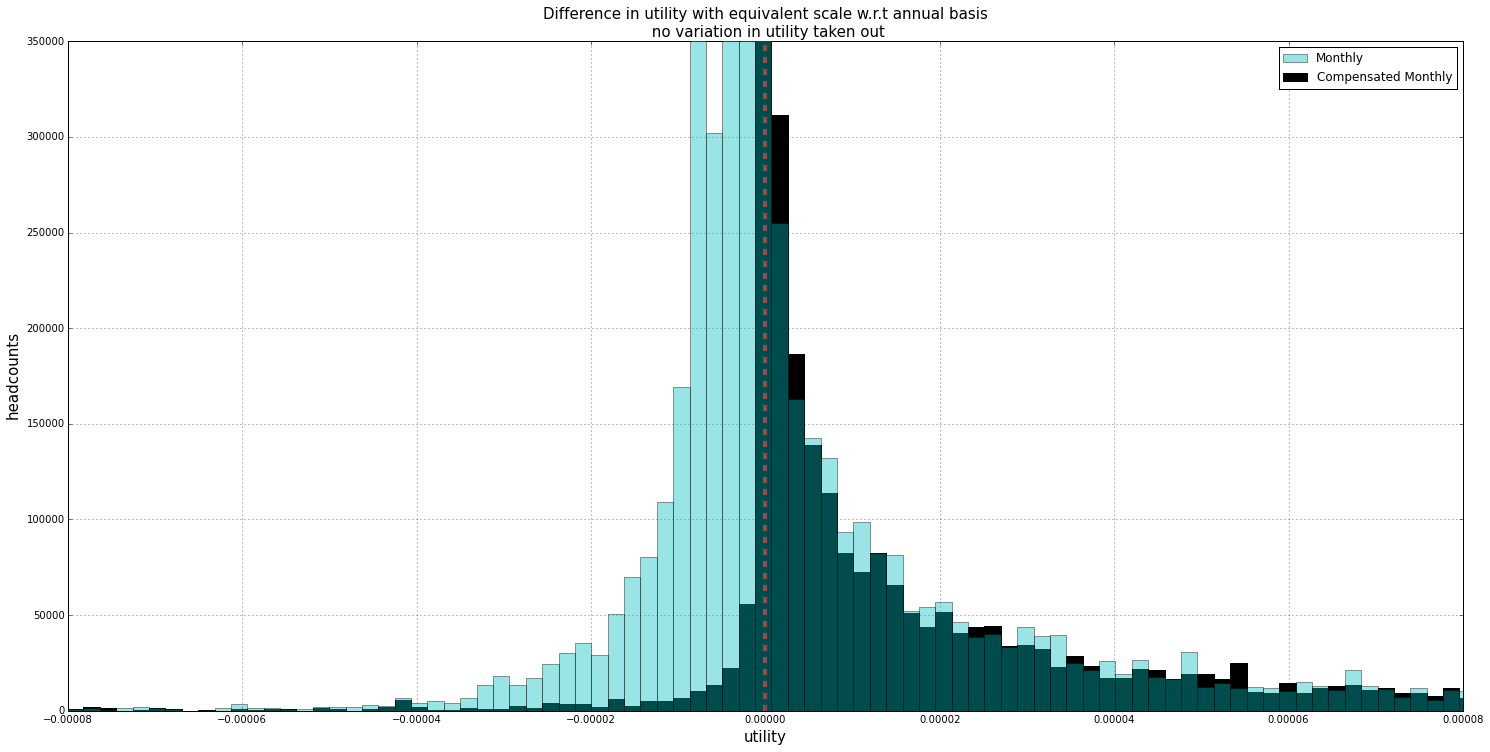

In [69]:
## Avec Echelles d'équivalences
#u_es_ir_m_rsa_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel_rsa_mensuel','2009'))
u_es_c_ir = pd.Series(survey_scenario.simulation.calculate_add('utility_es_compensated_ir_mensuel','2009'))
u_es_ir_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel','2009'))
u_es_ir_a = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_annuel','2009'))

execute_time_consuming_graph = True
if execute_time_consuming_graph == True : 

    weight_1 = pd.Series(weight_menages)[((u_es_ir_m - u_es_ir_a))!=0].values
    weight_2 = pd.Series(weight_menages)[((u_es_c_ir - u_es_ir_a))!=0].values
    bins = np.histogram(np.hstack(((u_es_ir_m - u_es_ir_a)[((u_es_ir_m - u_es_ir_a))!=0]
                                    ,(u_es_c_ir - u_es_ir_a)[((u_es_c_ir - u_es_ir_a))!=0]
            )), bins = 7000)[1]
    
    hist1 = ((u_es_ir_m - u_es_ir_a))[((u_es_ir_m - u_es_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_1, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_es_c_ir - u_es_ir_a))[((u_es_c_ir - u_es_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_2,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

    plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
    plt.ylim(0,35*10**4)
    plt.xlim(-0.00008, 0.00008)
    plt.legend()
    plt.title("Difference in utility with equivalent scale w.r.t annual basis \n no variation in utility taken out", size = 15)
    plt.xlabel('utility', size = 15)
    plt.ylabel('headcounts', size = 15)

### Vickrey utility 

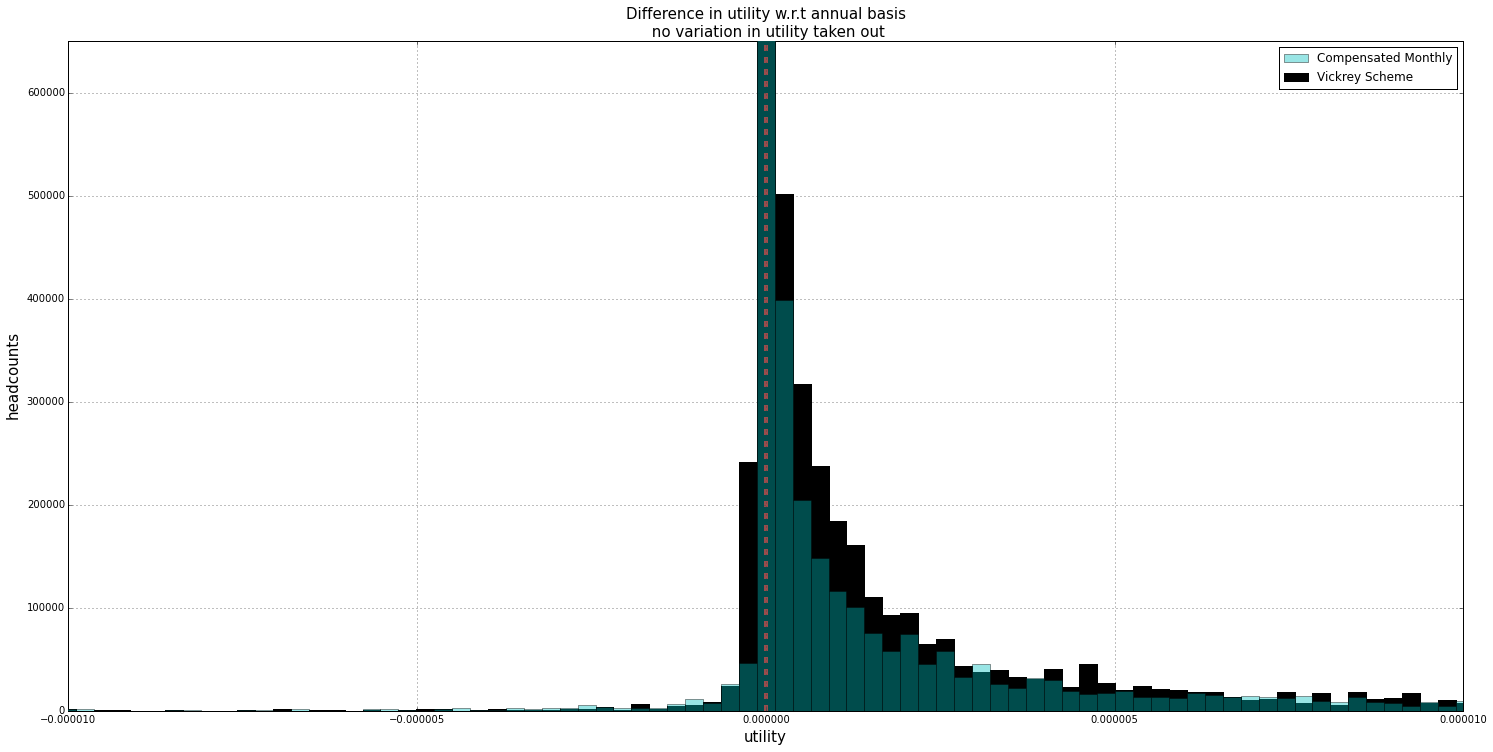

In [70]:
execute_time_consuming_graph = True
if execute_time_consuming_graph == True : 

    weight_1 = pd.Series(weight_menages)[((u_ir_m - u_ir_a))!=0].values
    weight_2 = pd.Series(weight_menages)[((u_c_ir - u_ir_a))!=0].values
    weight_3 = pd.Series(weight_menages)[((u_vickrey - u_ir_a))!=0].values
    bins = np.histogram(np.hstack(((u_ir_m - u_ir_a)[((u_ir_m - u_ir_a))!=0]
                                    ,(u_c_ir - u_ir_a)[((u_c_ir - u_ir_a))!=0], (u_vickrey - u_ir_a)[((u_vickrey - u_ir_a))!=0]
            )), bins = 2200)[1]
    
#    hist1 = ((u_ir_m - u_ir_a))[((u_ir_m - u_ir_a))!=0].hist(figsize = (25,12), bins=bins,
#                                                             weights = weight_1, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_c_ir - u_ir_a))[((u_c_ir - u_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_2,zorder=10, color = 'c',alpha = 0.4, label = "Compensated Monthly")
    hist3 = ((u_vickrey - u_ir_a))[((u_vickrey - u_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_3,zorder=1, color = 'k',alpha = 1, label = "Vickrey Scheme")

    plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
    plt.ylim(0,65*10**4)
    plt.xlim(-0.00001, 0.00001)
    plt.legend()
    plt.title("Difference in utility w.r.t annual basis \n no variation in utility taken out", size = 15)
    plt.xlabel('utility', size = 15)
    plt.ylabel('headcounts', size = 15)

In [71]:
print (((u_c_ir - u_ir_a)) < -0.0000001).value_counts()
print (((u_vickrey - u_ir_a))< -0.0000001).value_counts()
print (((u_c_ir - u_ir_a))[((u_c_ir - u_ir_a))!=0] < -0.0000001).value_counts()
print (((u_vickrey - u_ir_a))[((u_vickrey - u_ir_a))!=0] < -0.0000001).value_counts()

False    48732
True       284
dtype: int64
False    48312
True       704
dtype: int64
False    5598
True      284
dtype: int64
False    10958
True       704
dtype: int64


In [72]:
print 284 / (48732+284), "% of the individuals loose with compensated tax scheme (if variation is over 0.0000001)"
print 704/(10958+704), "% of the individuals loose with Vickrey tax scheme (if variation is over 0.0000001)"

print 284 / (5598+284), "% of the individuals having a variation in utility with  loose with compensated tax scheme"
print 704/(10958+704), "% of the individuals having a variation in utility with Vickrey loose with Vickrey tax scheme"
 

0.00579402644035 % of the individuals loose with compensated tax scheme (if variation is over 0.0000001)
0.0603670039444 % of the individuals loose with Vickrey tax scheme (if variation is over 0.0000001)
0.0482828969738 % of the individuals having a variation in utility with  loose with compensated tax scheme
0.0603670039444 % of the individuals having a variation in utility with Vickrey loose with Vickrey tax scheme


### TODO : regarder combien font en moyenne les - 0.0000001 utility points de différence en monney metric.

In [73]:
print ((u_c_ir - u_ir_a))[(
                            ((u_c_ir - u_ir_a)!=0)&
                            (np.abs(u_c_ir - u_ir_a))<.00002)
                               ].shape

weight_2 = pd.Series(weight_menages)[(
                            ((u_c_ir - u_ir_a)!=0)&
                            (np.abs(u_c_ir - u_ir_a))<.00002)].values
print weight_2.shape

(43134,)
(43134,)


In [74]:
(((u_c_ir - u_ir_a)!=0)&
                                (np.abs(u_c_ir - u_ir_a))<.00002).value_counts()

True     43134
False     5882
dtype: int64

In [75]:
(((u_c_ir - u_ir_a)!=0)&
    (np.abs(u_c_ir - u_ir_a))<.00002).value_counts()

True     43134
False     5882
dtype: int64

In [76]:
bins-100

array([-100.00023242, -100.00023216, -100.00023191, ...,  -99.99966762,
        -99.99966737,  -99.99966711])

## Annexes

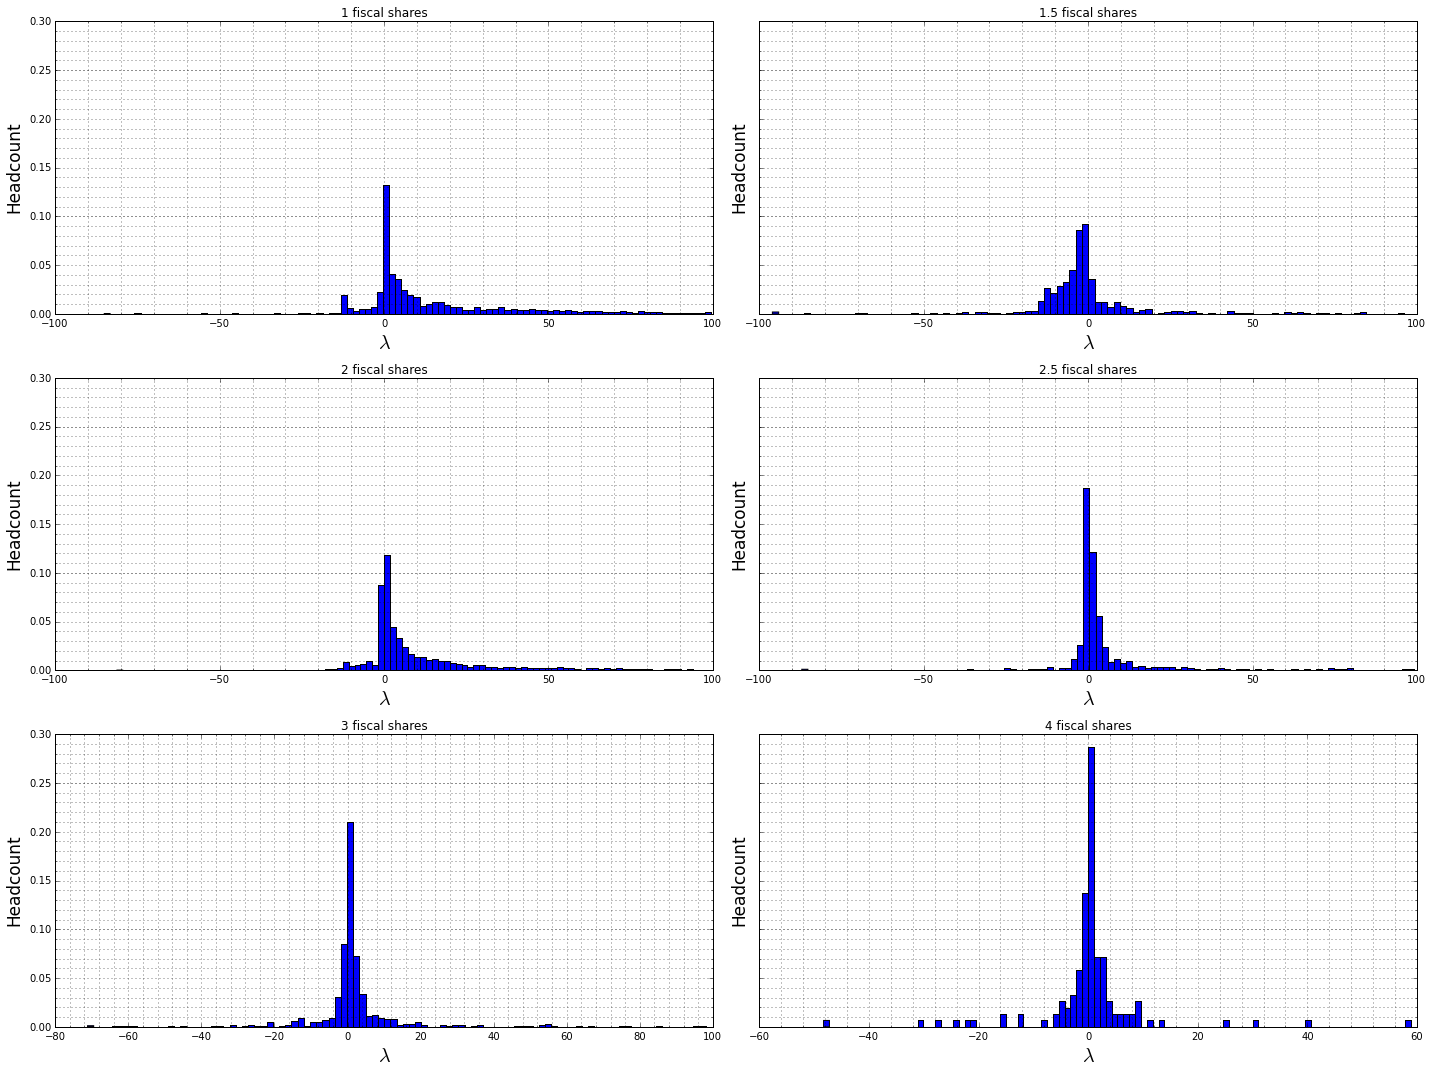

In [77]:
nb_minor_ticks = 5

lambda_compensation = survey_scenario.simulation.calculate("lambda_compensation", period.this_year)
nb_parts_list = [1,1.5,2,2.5,3,4]
graph_filter = (np.abs(lambda_compensation)>.1)&(np.abs(lambda_compensation)<100)

nb_subplots_lines = len(nb_parts_list)//2 + len(nb_parts_list)%2 

fig, ax = plt.subplots(nb_subplots_lines,2,sharey = True, figsize = (20, 15), tight_layout = True)
count = 0
for parts in nb_parts_list:
    graph_filter = (np.abs(lambda_compensation)>.001)&(np.abs(lambda_compensation)<100) & (simulation.calculate('nbptr') == parts)
    i = count//2
    j = count %2
    
    ax[i,j].hist(lambda_compensation[graph_filter], bins = 100, normed = True)#, weights = poids.values)
    ax[i,j].set_xlabel(r'$\lambda$',fontsize = 20 )
    ax[i,j].set_ylabel('Headcount',fontsize = 17)
    ax[i,j].set_title('{} fiscal shares'.format(parts))
    ax[i,j].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
    ax[i,j].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
    ax[i,j].grid(which = 'both')
    count +=1
#plt.savefig("image_result_of_mensualisation/lambda_compensation_by_fiscal_shares.png")

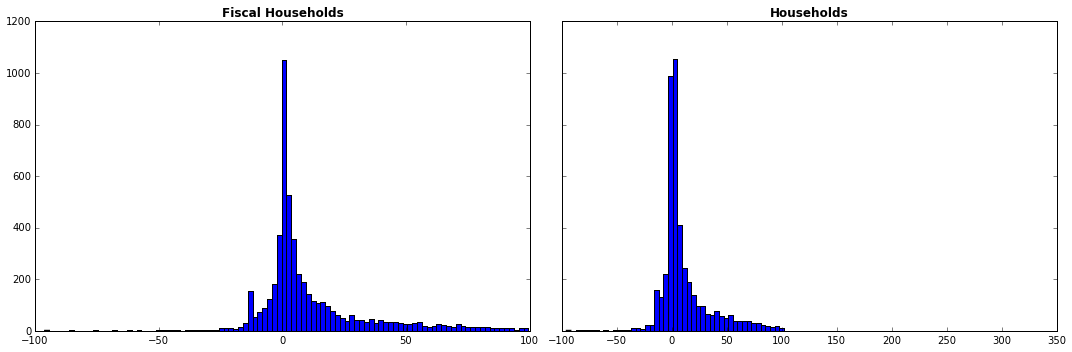

In [78]:
nb_minor_ticks = 5


weights = weight_foyers/sum(weight_foyers)



lambda_compensation = survey_scenario.simulation.calculate("lambda_compensation", period.this_year)
lambda_compensation_household = switch_array_entity(lambda_compensation,'foyer_fiscal', 'menage')

graph_filter = (np.abs(lambda_compensation)>.1)&(np.abs(lambda_compensation)<100)
graph_filter_household = switch_array_entity(graph_filter, 'foyer_fiscal', 'menage').astype('bool')
fig, ax = plt.subplots(1,2,sharey = True, figsize = (15, 5), tight_layout = True)

weights = weight_foyers[graph_filter]/sum(weight_foyers[graph_filter])
ax[0].hist(lambda_compensation[graph_filter], bins = 100)
ax[0].set_title("Fiscal Households", weight = "bold")
ax[1].hist(pd.Series(lambda_compensation_household[graph_filter_household]).dropna(), bins = 100)
ax[1].set_title("Households", weight = "bold")

AttributeError: 'DataFrame' object has no attribute 'yearly_income'

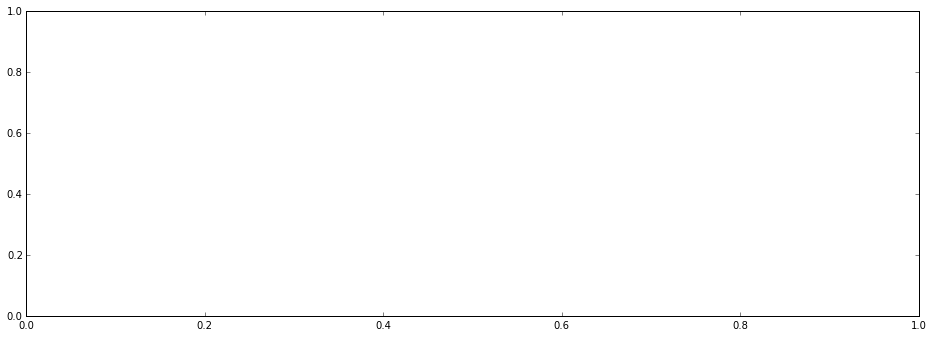

In [79]:

smooth =4

fig = plt.figure(figsize=(16, 12))
ax1 = plt.subplot2grid((2,2), (0,0), colspan=2)

plt.figure()
rev_max = 175000
bins_to_graph = df_m[(df_m.yearly_income>0)&(df_m.yearly_income<175000)].yearly_income.quantile(np.arange(0,1.1,0.1))
n,bins,patches = plt.hist(df_m[((df_m.yearly_income>0)&(df_m.yearly_income<rev_max)) & 
                             (df_m.relative_var>0.2)].yearly_income.values, 
                              bins= bins_to_graph.values
                         )
plt.close() #do not display first plots

plt.figure()
rev_max = 175000
bins_to_graph = df_m[(df_m.yearly_income>0)&(df_m.yearly_income<175000)].yearly_income.quantile(np.arange(0,1.1,0.1))
n2,bins2,patches2 = plt.hist(df_m[((df_m.yearly_income>0)&
                                 (df_m.yearly_income<rev_max))].yearly_income.values,
                             bins= bins_to_graph.values)
plt.close() #do not display first plots
width_list = []
for i in range(0,bins2.shape[0]-1):
    width_list.append(bins2[i]-bins2[i+1])
ax1.bar( bins2[1::], n/n2,width = width_list, alpha = 0.5)
ax1.grid()
ax1.set_xlim([0,100000])
ax1.set_title("Households")
ax1_2 = ax1.twinx()
ax1_2.plot(rbg_test_case[1:][::smooth],global_marginal_rate[::smooth], 'k', label = "global marginal tax rate")
ax1_2.set_ylim(0,1)
ax1.set_xlim(0,70000)



ax3 = plt.subplot2grid((2,2), (1,0), colspan=1)


plt.figure()
rev_max = 175000
bins_to_graph = df[(df.yearly_income>0)&(df.yearly_income<175000)].yearly_income.quantile(np.arange(0,1.1,0.1))
n,bins,patches = plt.hist(df[((df.yearly_income>0)&(df.yearly_income<rev_max)) & 
                             (df.relative_var>0.2)].yearly_income.values, 
                              bins= bins_to_graph.values
                         )
plt.close() #do not display first plots

plt.figure()
rev_max = 175000
bins_to_graph = df[(df.yearly_income>0)&(df.yearly_income<175000)].yearly_income.quantile(np.arange(0,1.1,0.1))
n2,bins2,patches2 = plt.hist(df[((df.yearly_income>0)&
                                 (df.yearly_income<rev_max))].yearly_income.values,
                             bins= bins_to_graph.values)
plt.close() #do not display first plots
width_list = []
for i in range(0,bins2.shape[0]-1):
    width_list.append(bins2[i]-bins2[i+1])
ax3.bar( bins2[1::], n/n2,width = width_list, alpha = 0.5)
ax3.grid()
ax3_2 = ax3.twinx()
ax3_2.plot(rbg_test_case[1:][::smooth],global_marginal_rate[::smooth], 'k', label = "global marginal tax rate")
ax3_2.set_ylim(0,1)

ax3.set_xlim([0,75000])
ax3.set_title("Individuals")


ax2 = plt.subplot2grid((2,2), (1,1), colspan=1)


plt.figure()
rev_max = 175000
bins_to_graph = df_f[(df_f.yearly_income>0)&(df_f.yearly_income<175000)].yearly_income.quantile(np.arange(0,1.1,0.1))
n,bins,patches = plt.hist(df_f[((df_f.yearly_income>0)&(df_f.yearly_income<rev_max)) & 
                             (df_f.relative_var>0.2)].yearly_income.values, 
                              bins= bins_to_graph.values
                         )
plt.close() #do not display first plots

plt.figure()
rev_max = 175000
bins_to_graph = df_f[(df_f.yearly_income>0)&(df_f.yearly_income<175000)].yearly_income.quantile(np.arange(0,1.1,0.1))
n2,bins2,patches2 = plt.hist(df_f[((df_f.yearly_income>0)&
                                 (df_f.yearly_income<rev_max))].yearly_income.values,
                             bins= bins_to_graph.values)
plt.close() #do not display first plots
width_list = []
for i in range(0,bins2.shape[0]-1):
    width_list.append(bins2[i]-bins2[i+1])
ax2.bar( bins2[1::], n/n2,width = width_list, alpha = 0.5)
ax2.grid()
ax2_2 = ax2.twinx()
ax2_2.plot(rbg_test_case[1:][::smooth],global_marginal_rate[::smooth], 'k', label = "global marginal tax rate")
ax2_2.set_ylim(0,1)

ax2.set_xlim([0,75000])
ax2.set_title("Fiscal Households")


In [ ]:
fig, axe = plt.subplots(6,2,figsize=(20, 20))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
for month in range(1,13):
    i = (month-1)//2 ; j= (month-1)%2
    ax = axe[i,j]
    
    gain_u = (pd.Series(
     survey_scenario.simulation.calculate("utility_ir_mensuel_rsa_mensuel", "2009-{}".format(month)) - 
survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
        ))
    gain_m =  (
        survey_scenario.simulation.calculate("inverted_utility_compenstaed_ir_mensuel_rsa_mensuel", "2009-{}".format(month)) - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))
    pd.DataFrame({'gain_utilite':gain_u, 'gain_argent':gain_m})
    ax.hist((gain_m)[(gain_m!=0)&(np.abs(gain_m)<300)], bins = 100)
    #ax.hist((gain_m)[(gain_m!=0)], bins = 1500)
    #print pd.Series(gain_m)[gain_m!=0].shape
    ax.set_xlim(-300,300)
    ax.set_xlabel("equivalent monetary gains in euros ")
    ax.set_ylabel('frequency')
    ax.set_title('{}'.format(calendar.month_name[month]), weight = 'bold')
#TODO: problème sur les 3 derniers mois !

In [ ]:
#TODO trouver pourquoi il n'y a pas de différences.
execute_time_consuming_graph = True
if execute_time_consuming_graph == True : 

    weight_1 = pd.Series(weight_menages)[((((u_ir_m - u_ir_a))!=0) &
                                (np.abs(u_ir_m - u_ir_a))<.00002) ].values
    weight_2 = pd.Series(weight_menages)[((((u_c_ir - u_ir_a))!=0)
                                        & (np.abs(u_c_ir - u_ir_a)<.00002))].values
    bins = np.histogram(np.hstack(((u_ir_m - u_ir_a)[((((u_ir_m - u_ir_a))!=0)
                                        & (np.abs(u_ir_m - u_ir_a)<.00002))]
                                    ,(u_c_ir - u_ir_a)[((((u_c_ir - u_ir_a))!=0)
                                        & (np.abs(u_c_ir - u_ir_a)<.00002))])
                                 ), bins = 140)[1]
    
    hist1 = ((u_ir_m - u_ir_a))[(((u_ir_m - u_ir_a)!=0)&
                                (np.abs(u_ir_m - u_ir_a))<.00002)
                               ].hist(figsize = (25,12), bins=bins,
                                            weights = weight_1, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_c_ir - u_ir_a))[((((u_c_ir - u_ir_a))!=0)
                                        & (np.abs(u_c_ir - u_ir_a)<.00002))
                               ].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_2,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

    #plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
    plt.ylim(0,35*10**4)
    plt.xlim(-0.00002, 0.00002)
    plt.legend()
    plt.title("Difference in utility w.r.t annual basis \n no variation in utility taken out", size = 15)
    plt.xlabel('utility', size = 15)
    plt.ylabel('headcounts', size = 15)

# Numbers and tables

## Welfare section

### Utility

#### Without ES

In [89]:
print "annual tax: ", simulation.calculate("utility_ir_annuel").sum()
print "monthly tax: ", simulation.calculate("utility_ir_mensuel").sum()
print "monthly c tax: ",simulation.calculate("utility_compensated_ir_mensuel").sum()
print "Vickrey tax: ",simulation.calculate("utility_ir_vickrey_mensuel").sum()

annual tax:  -6.11071
monthly tax:  -6.08902
monthly c tax:  -6.09044
Vickrey tax:  -6.07352


In [90]:
print "annual tax: ",survey_scenario.compute_aggregate("utility_ir_annuel")
print "monthly tax: ",survey_scenario.compute_aggregate("utility_ir_mensuel")
print "monthly c tax: ",survey_scenario.compute_aggregate("utility_compensated_ir_mensuel")
print "Vickrey tax: ",survey_scenario.compute_aggregate("utility_ir_vickrey_mensuel")

annual tax:  -3260.62376662
monthly tax:  -3247.74417401
monthly c tax:  -3249.04302428
Vickrey tax:  -3239.09325766


#### With ES

In [80]:
print survey_scenario.compute_aggregate("utility_es_ir_annuel")
print survey_scenario.compute_aggregate("utility_es_ir_mensuel")
print survey_scenario.compute_aggregate("utility_es_compensated_ir_mensuel")
print survey_scenario.compute_aggregate("utility_es_compensated_ir_mensuel")

-53559.2620323
-53365.1909868
-53391.5349039


In [ ]:
print(survey_scenario.simulation.calculate_add("utility_es_ir_annuel")* uc('menage') ).sum() 
print(survey_scenario.simulation.calculate_add("utility_es_ir_mensuel")* uc('menage') ).sum() 
print(survey_scenario.simulation.calculate_add("utility_es_compensated_ir_mensuel") * uc('menage') ).sum() 

In [81]:
print survey_scenario.compute_aggregate("utility_es_ir_annuel")
print survey_scenario.compute_aggregate("utility_es_ir_mensuel")
print survey_scenario.compute_aggregate("utility_es_compensated_ir_mensuel")


-53559.2620323
-53365.1909868
-53391.5349039


In [82]:
print(survey_scenario.simulation.calculate_add("utility_es_ir_annuel")* uc('menage') ).sum() 
print(survey_scenario.simulation.calculate_add("utility_es_ir_mensuel")* uc('menage') ).sum() 
print(survey_scenario.simulation.calculate_add("utility_es_compensated_ir_mensuel") * uc('menage') ).sum() 

-160.560060628
-160.10209081
-160.136144353


# End selected for article

In [ ]:
for month in range(1,13):
    gain_u = (pd.Series(
     survey_scenario.simulation.calculate("utility_ir_mensuel_rsa_mensuel", "2009-{}".format(month)) - 
survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
        ))
    gain_m =  (
        survey_scenario.simulation.calculate("inverted_utility_compenstaed_ir_mensuel_rsa_mensuel", "2009-{}".format(month)) - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))
    pd.DataFrame({'gain_utilite':gain_u, 'gain_argent':gain_m})
    plt.figure()
    pd.Series(gain_m)[(gain_m!=0)&(np.abs(gain_m)<300)].hist(bins = 100)
    #pd.Series(gain_m)[(gain_m!=0)].hist(bins = 1500)
    #print pd.Series(gain_m)[gain_m!=0].shape
    plt.xlim(-300,300)
    plt.xlabel("equivalent monetary gains in euros ")
    plt.ylabel('frequency')
#TODO: problème sur les 3 derniers mois !

In [ ]:
fig = plt.figure(figsize=(10, 9))
ax1 = plt.subplot2grid((2,2), (0,0), colspan=2)

ax1.plot(range_to_use,income_rep_func)




ax2 = plt.subplot2grid((2,2), (1,0), colspan=1)
ax2.plot(range_to_use,income_rep_func_f)
ax3 = plt.subplot2grid((2,2), (1,1), colspan=2)
ax3.plot(range_to_use,income_rep_func_m)


In [ ]:
sum_array_by_entity(month_income, 'menage')

In [ ]:
sum_array_by_entity(month_income, 'menage')

In [ ]:
plt.subplots()

In [ ]:
decote = simulation.calculate('decote')
decote_mensuel = simulation.calculate_add('decote_mensuel_times_12')/12


has_decote_difference = (np.abs(decote -decote_mensuel)>0.1).astype(bool)
has_decote_difference = cast_array_from_entity_to_role(has_decote_difference, 'foyer_fiscal', roles = [0])

fam_has_decote_diff = sum_array_by_entity(has_decote_difference, 'famille')

print pd.value_counts(fam_has_decote_diff)


#utility_loss = condition((u_c_ir - u_ir_a)<-0.00000001)
#utility_loss = cast_array_from_entity_to_role(utility_loss, roles = [0])


##### weights

In [ ]:
weight_foyers = survey_scenario.simulation.calculate_add('weight_foyers', period = period).astype(float)
weight_menages = survey_scenario.simulation.calculate_add('wprm', period = period).astype(float)
weight_familles = survey_scenario.simulation.calculate_add('weight_familles', period = period).astype(float)
weight_individus = survey_scenario.simulation.calculate_add('weight_individus', period = period).astype(float)

In [ ]:
print weight_foyers.shape , "foyers fiscaux"
print weight_menages.shape , "ménages"
print weight_familles.shape, "familles"
print weight_individus.shape, "individus"

In [ ]:
print weight_foyers.sum() , "foyers fiscaux"
print weight_menages.sum() , "ménages"
print weight_familles.sum(), "familles"
print weight_individus.sum(), "individus"

In [ ]:
variable = 'revdisp_mensuel_ir_mensuel'
monthly_df = pd.DataFrame(
                dict((column_name+"_"+period, survey_scenario.simulation.calculate_add(column_name, period)) 
                for period in ['{}-{}'.format( 2009, str(month).zfill(2)) for month in range(1, 13)] for column_name in [variable]) #TODO mensualize : allow for periods
                )
#monthly_df.T

In [ ]:
#monthly_df.T
monthly_df['revdisp_mensuel_ir_mensuel_2009-09'].mean()

In [12]:
survey_scenario.compute_aggregate('revdisp_mensuel_annuel')/27000000

30508.579552776522

In [ ]:
survey_scenario.compute_aggregate('revdisp_mensuel_ir_mensuel')/27000000

In [ ]:
survey_scenario.compute_aggregate('revdisp_mensuel_ir_mensuel')/27000000

#### Pourcentage du sample entre -20 et 20

In [ ]:
lambda_compensation = pd.Series(survey_scenario.simulation.calculate("lambda_compensation"))
lambda_compensation.loc[(lambda_compensation == -np.inf)|lambda_compensation.isnull()]=0
lambda_compensation.loc[(lambda_compensation == np.inf)|lambda_compensation.isnull()]=0
prct1 = lambda_compensation[np.abs(lambda_compensation)>70].shape[0]/lambda_compensation.shape[0]
print "{} % du sample à un lambda supérieur  à 70 ".format(round(prct1,2)*100)

#### Lambda compensation négatif du à la décote ?

In [ ]:
pd.Series(survey_scenario.simulation.calculate_add("decote_mensuel_times_12")/12).mean()

In [ ]:
decote_monthly = pd.Series(survey_scenario.simulation.calculate_add("decote_mensuel_times_12")/12)
decote_annual =  pd.Series(survey_scenario.simulation.calculate_add("decote"))

In [ ]:
filtre_unequal_decote = decote_monthly != decote_annual

In [ ]:
lambda_compensation[filtre_unequal_decote].shape

In [ ]:
lambda_compensation[filtre_unequal_decote&
                    (np.abs(lambda_compensation)>.1)&
                    (np.abs(lambda_compensation)<100)].hist(bins = 500)
plt.xlim(-20,20)

In [ ]:
graph_filter = filtre_unequal_decote & (np.abs(lambda_compensation)>.1) & (np.abs(lambda_compensation)<100)


to_graph_foyer = lambda_compensation[graph_filter]
poids = pd.Series(weight_foyers)[graph_filter]

plt.figure(figsize=(15,10))
plt.hist(to_graph_foyer.values, bins = 100, weights = poids.values)
plt.xlabel(r'$\lambda$',fontsize = 20 )
plt.ylabel('Headcount',fontsize = 17)

In [ ]:
graph_filter = filtre_unequal_decote & (np.abs(lambda_compensation)>.1)&(np.abs(lambda_compensation)<100)


to_graph_foyer = lambda_compensation[filtre_unequal_decote&
                    (np.abs(lambda_compensation)>.1)&
                    (np.abs(lambda_compensation)<100)]
poids = pd.Series(weight_foyers)[
        filtre_unequal_decote&
        (np.abs(lambda_compensation)>.1)&
        (np.abs(lambda_compensation)<100)]

plt.figure(figsize=(15,10))
plt.hist(to_graph_foyer.values, bins = 100, weights = poids.values)
plt.xlabel(r'$\lambda$',fontsize = 20 )
plt.ylabel('Headcount',fontsize = 17)

In [ ]:
#weights = np.ones_like(myarray)/float()


In [ ]:
lambda_compensation = survey_scenario.simulation.calculate("lambda_compensation", period.this_year)
nb_parts_list = [1,1.5,2,2.5,3,4]
graph_filter = (np.abs(lambda_compensation)>.1)&(np.abs(lambda_compensation)<100)

nb_subplots_lines = len(nb_parts_list)//2 + len(nb_parts_list)%2 

fig, ax = plt.subplots(nb_subplots_lines,2,sharey = True, figsize = (20, 15), tight_layout = True)
count = 0
for parts in nb_parts_list:
    graph_filter = (np.abs(lambda_compensation)>.001)&(np.abs(lambda_compensation)<100) & (simulation.calculate('nbptr') == parts)
    i = count//2
    j = count %2
    
    ax[i,j].hist(lambda_compensation[graph_filter].values, bins = 100, normed = True)#, weights = poids.values)
    ax[i,j].set_xlabel(r'$\lambda$',fontsize = 20 )
    ax[i,j].set_ylabel('Headcount',fontsize = 17)
    ax[i,j].set_title('{} fiscal shares'.format(parts))
    ax[i,j].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
    ax[i,j].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
    ax[i,j].grid(which = 'both')
    count +=1
plt.savefig("image_result_of_mensualisation/lambda_compensation_by_fiscal_shares.png")

In [ ]:
lambda_compensation_menage = pd.Series(switch_entity('lambda_compensation', 'menage'))
graph_filter_menage =  (np.abs(lambda_compensation_menage)>.1)&(np.abs(lambda_compensation_menage)<100)

In [ ]:
to_graph_foyer = lambda_compensation[graph_filter]
poids_menage = pd.Series(weight_menages)[graph_filter_menage]

plt.figure(figsize=(15,10))
plt.hist(to_graph_foyer.values, bins = 100, weights = poids.values)
plt.xlabel(r'$\lambda$',fontsize = 20 )
plt.ylabel('Headcount',fontsize = 17)

In [ ]:
from matplotlib.ticker import AutoMinorLocator
nb_minor_ticks = 5
fig, ax = plt.subplots(1,2,sharey = True, figsize = (20, 7), tight_layout = True)

to_graph_menage = lambda_compensation_menage[graph_filter_menage]
poids_menage = pd.Series(weight_menages)[graph_filter_menage]


ax[0].hist(to_graph_foyer.values, bins = 100, weights = poids.values)
ax[0].set_xlabel(r'$\lambda$',fontsize = 20 )
ax[0].set_ylabel('Headcount',fontsize = 17)
ax[0].set_title('Fiscal Household')
ax[0].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[0].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[0].grid(which = 'both')



ax[1].hist(to_graph_menage.values, bins = 100, weights = poids_menage.values)
ax[1].set_xlabel(r'$\lambda$',fontsize = 20)
#ax[1].set_ylabel('Headcount',fontsize = 17)
ax[1].set_title('Household')
ax[1].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[1].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[1].grid(which = 'both')

In [ ]:
from matplotlib.ticker import AutoMinorLocator
nb_minor_ticks = 5
fig, ax = plt.subplots(1,2,sharey = True, figsize = (20, 7), tight_layout = True)

to_graph_menage = lambda_compensation_menage[graph_filter_menage]
poids_menage = pd.Series(weight_menages)[graph_filter_menage]
ax_nb = 0
ax[ax_nb].hist(to_graph_foyer.values, bins = 100,normed = True, weights = poids.values)
ax[ax_nb].set_xlabel(r'$\lambda$',fontsize = 20 )
ax[ax_nb].set_ylabel('Headcount',fontsize = 17)
ax[ax_nb].set_title('Fiscal Household')
ax[ax_nb].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[ax_nb].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[ax_nb].grid(which = 'both')


ax_nb = 1
ax[ax_nb].hist(to_graph_menage.values, bins = 100, normed = True ,weights = poids_menage.values)
ax[ax_nb].set_xlabel(r'$\lambda$',fontsize = 20)
#ax[1].set_ylabel('Headcount',fontsize = 17)
ax[ax_nb].set_title('Household')
ax[ax_nb].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[ax_nb].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[ax_nb].grid(which = 'both')

In [ ]:
index_exceptional_lambda = lambda_compensation[np.abs(lambda_compensation)>100].index

In [ ]:
df = survey_scenario.create_data_frame_by_entity_key_plural(['decote_gain_fiscal','decote_gain_fiscal_mensuel_times_12',"irpp",'irpp_mensuel', 'lambda_compensation'])['foyers_fiscaux']
df['decote_gain_fiscal_mensuel'] = df.decote_gain_fiscal_mensuel_times_12/12
df.iloc[index_exceptional_lambda]

In [ ]:
survey_scenario.simulation.calculate("irpp_mensuel","2009-08")[4]

In [ ]:
df["difference"] = np.abs(df.decote_gain_fiscal- df.decote_gain_fiscal_mensuel)>0.01
df[lambda_compensation == -12].difference.value_counts()

In [ ]:
df.shape

In [ ]:
df[lambda_compensation == -12][['decote_gain_fiscal', 'decote_gain_fiscal_mensuel', 'lambda_compensation',"irpp",'irpp_mensuel' ]]

In [ ]:
df = survey_scenario.create_data_frame_by_entity_key_plural(['decote_gain_fiscal','decote_gain_fiscal_mensuel_times_12',"irpp",'irpp_mensuel', 'lambda_compensation'])['foyers_fiscaux']
df.decote_gain_fiscal_mensuel_times_12 = df.decote_gain_fiscal_mensuel_times_12/12
df.lambda_compensation[df.lambda_compensation>70] = 0 #autrement les histogrames prennent trois heures à grapher pour quelques observations
df.lambda_compensation[df.lambda_compensation< -70] = 0

In [ ]:
df[np.abs(df.decote_gain_fiscal-df.decote_gain_fiscal_mensuel_times_12)+1>0].shape

In [ ]:
df.lambda_compensation[(np.abs(df.decote_gain_fiscal-df.decote_gain_fiscal_mensuel_times_12)-1<0)
                      & (np.abs(df.lambda_compensation)>0.1)].hist(bins = 100)
plt.xlim(-20,20)

In [ ]:
df.lambda_compensation[(np.abs(df.decote_gain_fiscal-df.decote_gain_fiscal_mensuel_times_12)-0.1>0)
                      & (np.abs(df.lambda_compensation)>0.1)].mean()

In [ ]:
df[(np.abs(df.decote_gain_fiscal-df.decote_gain_fiscal_mensuel_times_12)-0.1>0)
                      & (np.abs(df.lambda_compensation)>0.1)]

In [ ]:
df[df.lambda_compensation<-1]

In [ ]:
df[df.lambda_compensation<-1][df.decote_gain_fiscal> df.decote_gain_fiscal_mensuel_times_12]

## Compensated irpp

In [ ]:
print max(pd.Series(survey_scenario.simulation.calculate_add('compensated_irpp_mensuel') -  survey_scenario.simulation.calculate_add('irpp')))
print min(pd.Series(survey_scenario.simulation.calculate_add('compensated_irpp_mensuel') -  survey_scenario.simulation.calculate_add('irpp')))

In [ ]:
df = survey_scenario.create_data_frame_by_entity_key_plural(['decote_gain_fiscal','decote_gain_fiscal_mensuel_times_12',"irpp",'irpp_mensuel', 'lambda_compensation', 'compensated_irpp_mensuel'])['foyers_fiscaux']
df.decote_gain_fiscal_mensuel_times_12 = df.decote_gain_fiscal_mensuel_times_12/12
#df.lambda_compensation[df.lambda_compensation>70] = 0 #autrement les histogrames prennent trois heures à grapher pour quelques observations
#df.lambda_compensation[df.lambda_compensation< -70] = 0
#df.compensated_irpp_mensuel = df.compensated_irpp_mensuel
df

In [ ]:
df = survey_scenario.create_data_frame_by_entity_key_plural(['decote_gain_fiscal','decote_gain_fiscal_mensuel_times_12',"irpp",'irpp_mensuel', 'lambda_compensation', 'compensated_irpp_mensuel'])['foyers_fiscaux']
df.decote_gain_fiscal_mensuel_times_12 = df.decote_gain_fiscal_mensuel_times_12/12
#df.lambda_compensation[df.lambda_compensation>70] = 0 #autrement les histogrames prennent trois heures à grapher pour quelques observations
#df.lambda_compensation[df.lambda_compensation< -70] = 0
#df.compensated_irpp_mensuel = df.compensated_irpp_mensuel
df

In [ ]:
df[df.compensated_irpp_mensuel - df.irpp<2][['irpp', 'compensated_irpp_mensuel', 'irpp_mensuel']]

In [ ]:
print survey_scenario.compute_aggregate('compensated_irpp_mensuel')
print survey_scenario.compute_aggregate('irpp')

In [ ]:
impot_mensuel_times_12 = survey_scenario.simulation.calculate("irpp_mensuel", period)*12
lambda_compensation = survey_scenario.simulation.calculate("lambda_compensation", period.this_year)



compensated_irpp = impot_mensuel_times_12/(12 + lambda_compensation)

In [ ]:
compensated_irpp[743]

In [ ]:
(survey_scenario.simulation.calculate("irpp", period.this_year) == 0)*0

In [ ]:
compensated_irpp = (survey_scenario.simulation.calculate("irpp", period.this_year) == 0) * 0 + \
                ~(survey_scenario.simulation.calculate("irpp", period.this_year) == 0) * np.nan_to_num(compensated_irpp) ;compensated_irpp[[4,743]]

In [ ]:
compensated_irpp = (
                (survey_scenario.simulation.calculate_add("irpp_mensuel", period) == 0) * #Condition
                (survey_scenario.simulation.calculate("irpp", period.this_year)/12) # on répartit sur l'année
            ) + ~(survey_scenario.simulation.calculate_add("irpp_mensuel", period) == 0) * compensated_irpp #condition opposée
compensated_irpp[[4,743]]

In [ ]:
df[df.lambda_compensation.isnull()]

In [ ]:
survey_scenario.simulation.calculate_add('irpp')

In [ ]:
survey_scenario.compute_aggregate('compensated_irpp_mensuel')

In [ ]:
lambda_compensation = survey_scenario.simulation.calculate('lambda_compensation')
np.all(lambda_compensation != np.nan)
lambda_compensation != np.nan
hello = lambda_compensation[1]
assert np.all(np.isfinite(lambda_compensation))


In [ ]:
sal_pen_df = survey_scenario.create_data_frame_by_entity_key_plural_with_monthly_basis_selector(['irpp'], ['irpp_mensuel','compensated_irpp_mensuel'])['foyers_fiscaux']

sal_pen_df.T

In [ ]:
survey_scenario.compute_aggregate('compensated_irpp_mensuel')

## Utility annalysis 

In [ ]:
survey_scenario.compute_aggregate("utility_ir_annuel") #TODO : find why Nan

In [ ]:
print pd.Series(survey_scenario.simulation.calculate_add('utility_ir_annuel','2009')).mean()
print pd.Series(survey_scenario.simulation.calculate_add('utility_ir_mensuel','2009')).mean()
print pd.Series(survey_scenario.simulation.calculate_add('utility_compensated_ir_mensuel','2009')).mean()
print pd.Series(survey_scenario.simulation.calculate_add('utility_ir_mensuel_rsa_mensuel','2009')).mean()

In [ ]:
u_ir_m_rsa_m = pd.Series(survey_scenario.simulation.calculate_add('utility_ir_mensuel_rsa_mensuel','2009'))
u_c_ir = pd.Series(survey_scenario.simulation.calculate_add('utility_compensated_ir_mensuel','2009'))
u_ir_m = pd.Series(survey_scenario.simulation.calculate_add('utility_ir_mensuel','2009'))
u_ir_a = pd.Series(survey_scenario.simulation.calculate_add('utility_ir_annuel','2009'))


In [ ]:
print u_ir_m_rsa_m.mean(),1/u_ir_m_rsa_m.mean()
print u_c_ir.mean(),1/u_c_ir.mean()
print u_ir_m.mean(),1/u_ir_m.mean()
print u_ir_a.mean(),1/u_ir_a.mean()

In [ ]:
print u_c_ir.describe()
print u_ir_m.describe()
print u_ir_a.describe()

In [ ]:
print 1/u_c_ir.describe()
print 1/u_ir_m.describe()
print 1/u_ir_a.describe()

In [ ]:
((u_ir_m - u_ir_a)).hist(bins = 500, figsize = (25,12))
plt.ylim(0,200)

In [ ]:
((u_ir_m - u_ir_a)<-0.0000001).value_counts()

In [ ]:
((u_c_ir - u_ir_a)).hist(bins = 500, figsize = (25,12))
plt.ylim(0,200)

In [ ]:
((u_c_ir - u_ir_a)<-0.0000001).value_counts()

##### Graphs with weights

In [ ]:
((u_ir_m - u_ir_a)).hist(bins = 500, figsize = (25,12), zorder=1, alpha = 0.7, weights = weight_menages,)
((u_c_ir - u_ir_a)).hist(bins = 500, figsize = (25,12), weights = weight_menages,zorder=10, alpha = 1)
plt.ylim(0,5*10**4)
plt.xlabel('utility')
plt.ylabel('headcounts')

In [ ]:
hist1 = ((u_ir_m - u_ir_a)).hist(bins = 200, figsize = (25,12), weights = weight_menages, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
hist2 = ((u_c_ir - u_ir_a)).hist(bins = 200, figsize = (25,12), weights = weight_menages,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
plt.ylim(0,20*10**4)
plt.xlim(-0.0005, 0.0005)
plt.legend()
plt.title("Difference in utility w.r.t annual basis", size = 15)
plt.xlabel('utility')
plt.ylabel('headcounts')

In [ ]:
hist1 = ((u_ir_m - u_ir_a)).hist(bins = 3000, figsize = (25,12), weights = weight_menages, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
hist2 = ((u_c_ir - u_ir_a)).hist(bins = 3000, figsize = (25,12), weights = weight_menages,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
#plt.ylim(0,70*10**5)
plt.xlim(-0.00002, 0.00002)
plt.legend()
plt.title("Difference in utility w.r.t annual basis", size = 15)
plt.xlabel('utility')
plt.ylabel('headcounts')

In [ ]:
weight_menages = pd.Series(weight_menages)

In [ ]:
execute_time_consuming_graph = True
if execute_time_consuming_graph == True : 

    hist1 = ((u_ir_m - u_ir_a))[((u_ir_m - u_ir_a))!=0].hist(bins = 7000, figsize = (25,12), weights = pd.Series(weight_menages)[((u_ir_m - u_ir_a))!=0].values, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_c_ir - u_ir_a))[((u_c_ir - u_ir_a))!=0].hist(bins = 7000, figsize = (25,12), weights = pd.Series(weight_menages)[((u_c_ir - u_ir_a))!=0].values,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

    plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
    plt.ylim(0,35*10**4)
    plt.xlim(-0.00002, 0.00002)
    plt.legend()
    plt.title("Difference in utility w.r.t annual basis \n no variation in utility taken out", size = 15)
    plt.xlabel('utility', size = 15)
    plt.ylabel('headcounts', size = 15)

In [ ]:
outliers = pd.Series(np.abs(((u_ir_m - u_ir_a))[((u_ir_m - u_ir_a))!=0])>0.00002).value_counts(normalize = True); outliers

In [ ]:
"This graph represent {}% of the tax-unit with varying utility, {}% of that sample are over 0.0002 utility points variation".format(outliers[0], outliers[1])

In [ ]:
pd.Series(weight_menages).shape

In [ ]:
decote = survey_scenario.simulation.calculate('decote_menage')
decote_mensuel = survey_scenario.simulation.calculate_add('decote_mensuel_menage')

In [ ]:
(pd.Series(survey_scenario.simulation.calculate_add('revdisp_mensuel_annuel'))[((u_c_ir - u_ir_a)<0)]).hist(bins = 100)

In [ ]:
pay_irpp = (simulation.calculate('irpp') > 0)
print pay_irpp.shape
pd.value_counts(cast_array_from_entity_to_role(pay_irpp, 'foyer_fiscal', roles = [0]))

In [ ]:
decote_mensuel = simulation.calculate_add("decote_gain_fiscal_mensuel_times_12")/12
decote = simulation.calculate_add("decote_gain_fiscal")


has_decote_difference = (np.abs(decote -decote_mensuel)>0.1).astype(int)
has_decote_difference = cast_array_from_entity_to_role(has_decote_difference, 'foyer_fiscal', roles = [0])

nb_decote_diff_menage = sum_array_by_entity(has_decote_difference, 'menage')

print pd.value_counts(nb_decote_diff_menage)


utility_loss = (u_c_ir - u_ir_a)<-0.00000001
pd.value_counts(nb_decote_diff_menage[utility_loss])

#utility_loss = condition((u_c_ir - u_ir_a)<-0.00000001)
#utility_loss = cast_array_from_entity_to_role(utility_loss, roles = [0])


In [ ]:
revdisp_loss = (simulation.calculate_add('revdisp_mensuel_compensated_ir_mensuel') - simulation.calculate_add('revdisp_mensuel_annuel')) < -1
#no_decote_or_payment_threshold_concern =  
good_rev_trav = switch_entity('rfr', 'menage')/switch_entity('nbptr', 'menage') > 20000
pd.value_counts(pd.Series(revdisp_loss)[good_rev_trav])

In [ ]:
dico = {} #bizare, qu'est-ce qu'il se passe exactement ?
a = 7
for month in range(1,13):
    dico[month] = zip(pd.Series(simulation.calculate("revdisp_mensuel_compensated_ir_mensuel", period = "2009-{}".format(month)))[good_rev_trav&revdisp_loss][a:a+1], 
                      pd.Series(simulation.calculate_add('revdisp_mensuel_compensated_ir_mensuel') - simulation.calculate_add('revdisp_mensuel_annuel'))[good_rev_trav&revdisp_loss][a:a+1],
                      pd.Series(switch_entity('irpp', 'famille'))[good_rev_trav&revdisp_loss][a:a+1],
                      
                     
                     )

In [ ]:
dico

In [ ]:
good_rev_trav.shape

In [ ]:
pd.Series(nb_decote_diff_menage.astype('bool'))[utility_loss == True].value_counts(normalize = True) #Parmis les ménages ayant eu une perte d'utilité 56% ont eu une différence de décote.

In [ ]:
pd.Series(nb_decote_diff_menage.astype('bool'))[utility_loss == True].value_counts(normalize = True) #Parmis les ménages ayant eu une perte d'utilité 56% ont eu une différence de décote.

In [ ]:
(nb_decote_diff_menage.astype('bool')*weight_menages.values).sum()/weight_menages.sum()

In [ ]:
nb_decote_diff_menage

In [ ]:
pd.Series(utility_loss)[nb_decote_diff_menage.astype('bool')].value_counts(normalize = True) #Parmis les ménages ayant eu une différence de décote 5% ont eu une perte d'utilité

In [ ]:
pd.Series(nb_decote_diff_menage.astype('bool'))[utility_loss == True].value_counts()

In [ ]:
u_c_ir.shape

In [ ]:
pd.value_counts(sum_array_by_entity(has_decote_difference, 'menage'))

In [ ]:
ax = ((pd.Series(np.abs(decote -decote_mensuel)>0.1)[((u_c_ir - u_ir_a)<-0.00000001)]).value_counts( normalize = True)*100).plot(kind = "bar",)
plt.ylim((0,100))

labels = ["{}%".format(np.round(i,2)) for i in ((pd.Series(np.abs(decote -decote_mensuel)>0.1)[((u_c_ir - u_ir_a)<-0.0000001)]).value_counts( normalize = True)*100) ] #0.000001 pour éviter les erreurs d'arrondis.
rects = ax.patches

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

In [ ]:
survey_scenario.simulation.persons.count

In [ ]:
is_decote_different = pd.Series(np.abs(decote -decote_mensuel)>0.1)[((u_c_ir - u_ir_a)<-0.00000001)]

In [ ]:
#TODO for famille and check if it coorrespond to the 46.43%
below_collection_thrshld = np.zeros(weight_foyers.shape[0], dtype=bool)
for month in range(1,13):
    irpp_mensuel = pd.Series(survey_scenario.simulation.calculate("irpp_mensuel", '2009-{}'.format(month)))
    below_collection_thrshld += (irpp_mensuel>1) & (irpp_mensuel<5.16)
    

In [ ]:
pd.Series(below_collection_thrshld).value_counts()

In [ ]:
np.array([True, False])+np.array([True, True])

In [ ]:
#Qui sont les gagnants ? :


In [ ]:
is_decote_different[is_decote_different==False]

In [ ]:
pd.Series(np.abs(decote -decote_mensuel)>0.1)[((u_c_ir - u_ir_a)<0.000001)].value_counts(normalize = True)

In [ ]:
(pd.Series(decote!= decote_mensuel)[((u_c_ir - u_ir_a)<0)]).hist(bins = 100)

In [ ]:
revdisp[(u_c_ir>=u_ir_a)]

In [ ]:
print u_c_ir[(decote_annual==0) & (decote_monthly==0)].mean()
print u_ir_m[(decote_annual==0) & (decote_monthly==0)].mean()
print u_ir_a[(decote_annual==0) & (decote_monthly==0)].mean()

## Qui sont les gagnants ?

In [ ]:
print pd.value_counts((survey_scenario.simulation.calculate_add("revdisp_mensuel_annuel")-survey_scenario.simulation.calculate_add("revdisp_mensuel_ir_mensuel"))>1)
print pd.value_counts((survey_scenario.simulation.calculate_add("revdisp_mensuel_annuel")-survey_scenario.simulation.calculate_add("revdisp_mensuel_ir_mensuel"))<-1)

In [ ]:
print pd.Series(((survey_scenario.simulation.calculate_add("revdisp_mensuel_annuel")-survey_scenario.simulation.calculate_add("revdisp_mensuel_ir_mensuel"))>1)
                     *weight_menages).sum()
print pd.Series(((survey_scenario.simulation.calculate_add("revdisp_mensuel_annuel")-survey_scenario.simulation.calculate_add("revdisp_mensuel_ir_mensuel"))<-1)
                      *weight_menages).sum()

In [ ]:
np.mean(
    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")>1]
    )

In [ ]:
plt.figure(figsize=(15,10))
plt.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")>1], bins = 200, label = "Paying less on monthly basis")
plt.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")<-1], bins = 65, color= 'r', label = "Paying more on monthly basis")
plt.xlim(0,50000)
plt.title("paying more or less")

###### Weighted

In [ ]:
from openfisca_utils import make_ready_to_use_simulation
from openfisca_core import rates
simulation = make_ready_to_use_simulation.make_ready_to_use_simulation(2009,False)
rbg_test_case = simulation.calculate('rbg')
irpp_test_case = simulation.calculate('irpp')
marginal_rate = rates.marginal_rate(irpp_test_case, rbg_test_case)-1
to_change = pd.Series(marginal_rate)[marginal_rate>1].index
#to_change = pd.Series(rates.marginal_rate(irpp_test_case, rbg_test_case)-1)[rates.marginal_rate(irpp_test_case, rbg_test_case)-1>1].index
marginal_rate[to_change] = marginal_rate[to_change+1]
plt.plot(marginal_rate)

In [ ]:
to_change = pd.Series(rates.marginal_rate(irpp_test_case, rbg_test_case)-1)[rates.marginal_rate(irpp_test_case, rbg_test_case)-1>1].index


In [ ]:
pd.Series(marginal_rate)[marginal_rate>1]

In [ ]:
np.mean(survey_scenario.simulation.calculate("rbg"))

In [ ]:
np.array([True,True,False]) *np.array([2,3,4])

In [ ]:
pd.value_counts((survey_scenario.simulation.calculate_add("revdisp_mensuel_annuel") - survey_scenario.simulation.calculate_add("revdisp_mensuel_compensated_ir_mensuel")>1))

In [ ]:


weights1 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")>1]
weights2 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")<-1]

fig, ax1 = plt.subplots(figsize=(20, 10))


ax1.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))>1], bins = 400, label = "Paying more on monthly basis", weights= weights1)
ax1.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))<-1], bins = 130, color= 'r', label = "Paying less on monthly basis",weights= weights2)


ax1.set_xlim(0,50000)
ax2 = plt.twinx()
ax2.plot(rbg_test_case[1:],marginal_rate, 'k', label = "marginal tax rate")
ax2.set_xlim(0,50000)
ax2.legend()
ax1.legend(bbox_to_anchor=(0.22, 1))
ax1.grid(which = 'both')
ax1.text(11000,500000, u"minimum wage", weight = 'bold',)
ax2.set_ylabel("marginal tax rate")
ax1.set_xlabel("Gross global income divided by fiscal shares")
ax1.set_ylabel("number of taxunit")
#plt.title("")


In [ ]:
-(100 -  110)

In [ ]:
survey_scenario.simulation.calculate_add("irpp_mensuel").mean()

### Gains monetaires

#### Same annalysis with benefits

In [ ]:
survey_scenario.compute_aggregate("rsa_socle_majore_mensualise")

In [ ]:
survey_scenario.compute_aggregate("rsa_non_majore")

In [ ]:
pd.Series(survey_scenario.simulation.calculate("rsa_eligibilite_tns", "2009-01")).value_counts()

# Utilitarian monetary gains

In [ ]:
monetary_gain_ir = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    monetary_gain_ir += (
    survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
    )*weight_menages

In [ ]:
((monetary_gain_ir.sum(0)/10)*12)/10**9

Gains moyens par ménages.

In [ ]:
monetary_gain_ir = pd.Series(monetary_gain_ir)
monetary_gains_ir_0 = monetary_gain_ir[monetary_gain_ir != 0]
monetary_gains_ir_0.hist(bins = 500, weights = (pd.Series(weight_menages)[monetary_gain_ir != 0]).values)
plt.xlim(-10000,10000)

In [ ]:
print pd.Series(monetary_gain_ir<-10).value_counts()
print pd.Series(monetary_gain_ir>10).value_counts()
pd.Series(monetary_gain_ir)[monetary_gain_ir>10].shape

In [ ]:
month = 7
gain = pd.Series(survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
    )
gain[np.abs(gain)>1].mean()


In [ ]:
 diff_in_income = pd.Series(
    np.abs(survey_scenario.simulation.calculate("revdisp_mensuel_annuel", "2009-{}".format(month))
          - survey_scenario.simulation.calculate("revdisp_mensuel_compensated_ir_mensuel", "2009-{}".format(month)))>1
    )

In [ ]:
weight_menages.sum(0)

In [ ]:
#monetary_gain.sum(0)/10**9

#### Non compensated

In [ ]:
for month in range(1,13):
    gain_u = (pd.Series(
     survey_scenario.simulation.calculate("utility_ir_mensuel", "2009-{}".format(month)) - 
survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
        ))
    gain_m =  (
        survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))
    pd.DataFrame({'gain_utilite':gain_u, 'gain_argent':gain_m})
    plt.figure()
    pd.Series(gain_m)[gain_m!=0].hist(bins = 1500)
    plt.xlim(-200,200)
    plt.xlabel("equivalent monetary gains in euros ")
    plt.ylabel('frequency')
#TODO: problème sur les 3 derniers mois !

In [ ]:
u_monetary_gain_ir = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    u_monetary_gain_ir += (
    survey_scenario.simulation.calculate("inverted_utility_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
    )*weight_menages

In [ ]:
((u_monetary_gain_ir.sum(0)/10)*12)/10**9

In [ ]:
u_monetary_gain_ir = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    u_monetary_gain_ir += np.mean(
    (survey_scenario.simulation.calculate("inverted_utility_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))*weight_menages
    )

In [ ]:
((u_monetary_gain_ir.sum(0)/10)*12)/10**9

In [ ]:
u_monetary_gain_ir = np.zeros(weight_menages.shape[0])
for month in range(1,12):
    u_monetary_gain_ir += (
    survey_scenario.simulation.calculate("inverted_utility_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
    )*weight_menages

In [ ]:
(u_monetary_gain_ir.sum(0))/10**9

In [ ]:
month = 6
gain = pd.Series(survey_scenario.simulation.calculate("inverted_utility_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
    )
mean_gain = gain[np.abs(gain)>1].mean()
print('{} gain on average'.format(mean_gain))

In [ ]:
u_monetary_gain = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    u_monetary_gain +=np.mean(
        pd.Series(survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))
               )
(((u_monetary_gain_ir/10)*12)/10**9).mean()  

#### mean monetary equivalent utility gain for each month

In [ ]:
u_money_gain = np.zeros(weight_menages.shape[0])
mean_gain = np.zeros(1)
for month in range(1,13):
    u_money_gain = pd.Series(survey_scenario.simulation.calculate("inverted_utility_ir_mensuel", "2009-{}".format(month)) - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
        )
    mean_gain += (u_money_gain[np.abs(u_money_gain)>1]).mean()
print('{} gain on average'.format(mean_gain[0]))

In [ ]:
#mean_gain = (u_gain[np.abs(u_gain)>1]).mean()

#### mean monetary equivalent utility gain over the year

In [ ]:
u_annuelle = pd.Series(np.zeros(weight_menages.shape[0]))
u_mensuelle = pd.Series(np.zeros(weight_menages.shape[0]))
mean_gain = np.zeros(1)
for month in range(1,13):
    u_annuelle += pd.Series(
        survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
        )
    u_mensuelle += pd.Series(survey_scenario.simulation.calculate("utility_ir_mensuel", "2009-{}".format(month)) 
        )
eq_money_u_annuelle = np.exp((np.log(-u_annuelle))/-.87)
eq_money_u_mensuelle = np.exp((np.log(-u_mensuelle))/-.87)
impact_filter = (u_annuelle != u_mensuelle)

print('{} gain on average'.format(eq_money_u_mensuelle.mean() - eq_money_u_annuelle.mean()))
print('{} gain on average for concerned taxunits'.format(eq_money_u_mensuelle[impact_filter].mean() - eq_money_u_annuelle[impact_filter].mean()))

#### Compensated

In [ ]:
for month in range(1,13):
    gain_u = (pd.Series(
     survey_scenario.simulation.calculate("utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
        ))
    gain_m =  (
        survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))
    pd.DataFrame({'gain_utilite':gain_u, 'gain_argent':gain_m})
    plt.figure()
    pd.Series(gain_m)[gain_m!=0].hist(bins = 1500)
    plt.xlim(-200,200)
    plt.xlabel("equivalent monetary gains in euros ")
    plt.ylabel('frequency')
#TODO: problème sur les 3 derniers mois !

In [ ]:
u_monetary_gain_ir = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    u_monetary_gain_ir += (
    survey_scenario.simulation.calculate("utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
    )*weight_menages

In [ ]:
((u_monetary_gain_ir.sum(0)/10)*12)/10**9

In [ ]:
u_monetary_gain_ir = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    u_monetary_gain_ir += np.mean(
    (survey_scenario.simulation.calculate("utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))*weight_menages
    )

In [ ]:
((u_monetary_gain_ir.sum(0)/10)*12)/10**9

In [ ]:
month = 7
gain = pd.Series(survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
    )
mean_gain = gain[np.abs(gain)>1].mean()
print('{} gain on average'.format(mean_gain))

In [ ]:
u_monetary_gain = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    u_monetary_gain +=np.mean(
        pd.Series(survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))
               )
(((u_monetary_gain_ir/10)*12)/10**9).mean()  

#### mean monetary equivalent utility gain over the year

In [ ]:
u_annuelle = pd.Series(np.zeros(weight_menages.shape[0]))
u_mensuelle = pd.Series(np.zeros(weight_menages.shape[0]))
mean_gain = np.zeros(1)
for month in range(1,13):
    u_annuelle += pd.Series(
        survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
        )
    u_mensuelle += pd.Series(survey_scenario.simulation.calculate("utility_compensated_ir_mensuel", "2009-{}".format(month)) 
        )
eq_money_u_annuelle = np.exp((np.log(-u_annuelle))/-.87)
eq_money_u_mensuelle = np.exp((np.log(-u_mensuelle))/-.87)
impact_filter = (u_annuelle != u_mensuelle)

print('{} gain on average'.format(eq_money_u_mensuelle.mean() - eq_money_u_annuelle.mean()))
print('{} gain on average for concerned taxunits'.format(eq_money_u_mensuelle[impact_filter].mean() - eq_money_u_annuelle[impact_filter].mean()))


In [ ]:
u_annuelle = pd.Series(np.zeros(weight_menages.shape[0]))
u_mensuelle = pd.Series(np.zeros(weight_menages.shape[0]))
mean_gain = np.zeros(1)
for month in range(1,13):
    u_annuelle += pd.Series(
        survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
        )
    u_mensuelle += pd.Series(survey_scenario.simulation.calculate("utility_ir_mensuel_rsa_mensuel", "2009-{}".format(month)) 
        )
eq_money_u_annuelle = np.exp((np.log(-u_annuelle))/-.87)
eq_money_u_mensuelle = np.exp((np.log(-u_mensuelle))/-.87)
impact_filter = (u_annuelle != u_mensuelle)

print('{} gain on average'.format(eq_money_u_mensuelle.mean() - eq_money_u_annuelle.mean()))
print('{} gain on average for concerned taxunits'.format(eq_money_u_mensuelle[impact_filter].mean() - eq_money_u_annuelle[impact_filter].mean()))


### RSA+IR

In [ ]:
for month in range(1,13):
    gain_u = (pd.Series(
     survey_scenario.simulation.calculate("utility_ir_mensuel_rsa_mensuel", "2009-{}".format(month)) - 
survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
        ))
    gain_m =  (
        survey_scenario.simulation.calculate("inverted_utility_compenstaed_ir_mensuel_rsa_mensuel", "2009-{}".format(month)) - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))
    pd.DataFrame({'gain_utilite':gain_u, 'gain_argent':gain_m})
    plt.figure()
    pd.Series(gain_m)[(gain_m!=0)&(np.abs(gain_m)<300)].hist(bins = 100)
    #pd.Series(gain_m)[(gain_m!=0)].hist(bins = 1500)
    print pd.Series(gain_m)[gain_m!=0].shape
    plt.xlim(-300,300)
    plt.xlabel("equivalent monetary gains in euros ")
    plt.ylabel('frequency')
#TODO: problème sur les 3 derniers mois !

In [ ]:
temp = pd.Series(gain_m)

In [ ]:
pd.Series(survey_scenario.simulation.calculate("inverted_utility_compenstaed_ir_mensuel_rsa_mensuel", "2009-{}".format(month))).value_counts()

In [ ]:
pd.Series(survey_scenario.simulation.calculate("utility_compensated_ir_mensuel_rsa_mensuel", "2009-{}".format(month))).value_counts()

In [ ]:
monetary_gain_ir_rsa = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    monetary_gain_ir_rsa += (
    survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel_rsa_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
    )*weight_menages

In [ ]:
((monetary_gain_ir_rsa.sum(0)/10)*12)/10**9

## Gains et perte passage à la retraite.

In [ ]:
print survey_scenario.simulation.persons.simulation.entity_by_key_plural

In [ ]:
coucou.entity.simulation

In [ ]:
c = np.zeros(1)
a = np.array([1,2,3])
b = np.array([True,True,False])
c += a[b]; c

In [ ]:
is_retired = np.zeros(weight_individus.shape[0])
is_active = np.zeros(weight_individus.shape[0])
is_inactive = np.zeros(weight_individus.shape[0])
for month in range(1,13):
    is_retired += survey_scenario.simulation.calculate("retraite_imposable", "2009-{}".format(month))>0
    is_active += survey_scenario.simulation.calculate("salaire_imposable", "2009-{}".format(month))>0
    is_inactive += (survey_scenario.simulation.calculate("salaire_imposable", "2009-{}".format(month)) + survey_scenario.simulation.calculate("retraite_imposable", "2009-{}".format(month))) == 0

In [ ]:
(pd.Series(is_retired + is_active + is_inactive).hist(bins= 12))

In [ ]:
is_retired = np.zeros(weight_individus.shape[0])
is_active = np.zeros(weight_individus.shape[0])
is_inactive = np.zeros(weight_individus.shape[0])
is_retire_active = np.zeros(weight_individus.shape[0])

for month in range(1,13):
    retraite_imposable = survey_scenario.simulation.compute("retraite_imposable", "2009-{}".format(month))
    salaire_imposable = survey_scenario.simulation.compute("salaire_imposable", "2009-{}".format(month))
    is_retired += retraite_imposable.array >0
    is_active += salaire_imposable.array > 0 
    is_retire_active += (retraite_imposable.array >0) & (salaire_imposable.array > 0 )
    is_inactive += (retraite_imposable.array == 0) & (salaire_imposable.array == 0 )
    

In [ ]:
is_retire_is_active_not_retire_active = ((is_retire_active == 0)
                                         & (is_active>0)
                                         & (is_inactive >0)
                                         )

In [ ]:
survey_scenario.simulation.tax_benefit_system.Variable.formula_class.sum_by_entity(retraite_imposable)

In [ ]:
survey_scenario.simulation.tax_benefit_system.Variable.formula_class.sum_by_entity('h')

In [ ]:
 type(class_name.encode('utf-8'), (Reform.DatedVariable,), definitions_by_name)

In [ ]:
pd.Series(is_retire_is_active_not_retire_active).value_counts()

In [ ]:
(pd.Series(is_retired + is_active + is_inactive)).value_counts()

In [ ]:
passage_a_la_retraite = pd.Series(is_retired) & pd.Series(is_not_retired)

## Revdisp over the year

## Annual IR Basis

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel', 'psoc_mensuel', 'ppe']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
    temp['impo'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo', "2009".format(month))))/12
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy

#### With weight

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel',]:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_individus))
    for var in ['psoc_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_familles))      
    temp['impo'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo', "2009".format(month))* weight_menages))/12
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
    

revdisp_oy.index = range(1,13)
revdisp_oy/10**9

In [ ]:
print (revdisp_oy/10**9).to_latex()

In [ ]:
ax = revdisp_oy.plot(kind = 'bar', stacked = 'True',alpha = 0.6, figsize=(15,9) )
#ax = fig.add_subplot(111)

plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.9)

plt.xlabel("months", fontsize = 15)
plt.ylabel("euros", fontsize = 15)
plt.legend( bbox_to_anchor=(1, 0, 1, 1), loc=3,)
plt.savefig("image_result_of_mensualisation/revdisp_ir_annual.png")

## Monthly Basis

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel', 'psoc_mensuel', 'ppe']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo_mensuel', "2009-{}".format(month))))
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy

### With weight

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_individus))
    for var in ['psoc_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_familles))      
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo_mensuel', "2009-{}".format(month))* weight_menages))
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))*weight_individus))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)

revdisp_oy.index = range(1,13)
revdisp_oy/10**9

In [ ]:
ax = revdisp_oy.plot(kind = 'bar', stacked = 'True',alpha = 0.6, figsize=(15,9) )
#ax = fig.add_subplot(111)

plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.9)

plt.xlabel("months", fontsize = 15)
plt.ylabel("euros", fontsize = 15)
plt.legend( bbox_to_anchor=(1, 0, 1, 1), loc=3,)
plt.savefig("image_result_of_mensualisation/revdisp_ir_monthly.png")

In [ ]:
revdisp_oy['total'] = revdisp_oy.sum(1)
print (revdisp_oy/10**9).to_latex()

## Compensated Monthly Basis

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel', 'psoc_mensuel', 'ppe']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('compensated_impo_mensuel', "2009-{}".format(month))))
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy

### With weight

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_individus))
    for var in ['psoc_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_familles))      
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('compensated_impo_mensuel', "2009-{}".format(month))* weight_menages))
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))*weight_individus))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy/10**9

In [ ]:
ax = revdisp_oy.plot(kind = 'bar', stacked = 'True',alpha = 0.6, figsize=(15,9) )
#ax = fig.add_subplot(111)

plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.9)

plt.xlabel("months", fontsize = 15)
plt.ylabel("euros", fontsize = 15)
plt.legend( bbox_to_anchor=(1, 0, 1, 1), loc=3,)
plt.savefig("image_result_of_mensualisation/revdisp_ir_comp_monthly.png")

In [ ]:
revdisp_oy['total'] = revdisp_oy.sum(1)
print (revdisp_oy/10**9).to_latex()

## Compensated Rsa monthly

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel', 'psoc_mensuel_rsa_mensuel', 'ppe']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('compensated_impo_mensuel', "2009-{}".format(month))))
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy

### With weight

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_individus))
    for var in ['psoc_mensuel_rsa_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_familles))      
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('compensated_impo_mensuel', "2009-{}".format(month))* weight_menages))
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))*weight_individus))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy/10**9

In [ ]:
ax = revdisp_oy.plot(kind = 'bar', stacked = 'True',alpha = 0.6, figsize=(15,9) )
#ax = fig.add_subplot(111)

plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.9)

plt.xlabel("months", fontsize = 15)
plt.ylabel("euros", fontsize = 15)
plt.legend( bbox_to_anchor=(1, 0, 1, 1), loc=3,)
plt.savefig("image_result_of_mensualisation/revdisp_rsa_ir_comp_monthly.png")

In [ ]:
revdisp_oy['total'] = revdisp_oy.sum(1)
print (revdisp_oy/10**9).to_latex()

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['rev_trav_mensuel', 'pen_mensuel', 'chomage_imposable', 'pen_mensuel', 'ppe']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
    temp['psoc_mensuel'] = - pd.Series(np.sum(survey_scenario.simulation.calculate('psoc_mensuel', "2009-{}".format(month))))
    temp['impo'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy

In [ ]:

undecompsed_revdisp = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    temp['revdisp_mensuel_annuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('revdisp_mensuel_annuel', "2009-{}".format(month))))
    undecompsed_revdisp = undecompsed_revdisp.append(temp, ignore_index=True)
    

In [ ]:
undecompsed_revdisp.index = range(1,13)

In [ ]:
df1 = pd.DataFrame({'revdisp_mensuel_annuel':revdisp_oy.sum(1).values}) 
df1.index = range(1,13)
(df1 - undecompsed_revdisp)/10**9

In [ ]:
undecompsed_revdisp.index = np.arange(-0.5,11.5,1)

In [ ]:
undecompsed_revdisp.index = np.arange(-0.5,11.5, 1) #TODO: pouruoi une différence ?
ax = revdisp_oy.plot(kind = 'bar', stacked = 'True',alpha = 0.2, figsize=(15,9) )
#ax = fig.add_subplot(111)
plt.bar(undecompsed_revdisp.index, undecompsed_revdisp.values, color = 'k', alpha = 0.4)
plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.5)

plt.xlabel("months", fontsize = 15)
plt.ylabel("headcount", fontsize = 15)
plt.legend( bbox_to_anchor=(1, 0, 1, 1), loc=3,)

In [ ]:
undecompsed_revdisp.index = np.arange(-0.5,11.5, 1) #TODO: pouruoi une différence ?
ax = revdisp_oy.plot(kind = 'bar', stacked = 'True',alpha = 0.6, figsize=(15,9) )
#ax = fig.add_subplot(111)

plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.9)

plt.xlabel("months", fontsize = 15)
plt.ylabel("headcount", fontsize = 15)
plt.legend( bbox_to_anchor=(1, 0, 1, 1), loc=3,)

In [ ]:
undecompsed_revdisp


## Monthly IR basis 

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel', 'psoc_mensuel', 'ppe', 'impo_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
        temp['psoc_mensuel'] = - pd.Series(np.sum(survey_scenario.simulation.calculate('psoc_mensuel', "2009-{}".format(month))))
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy
revdisp_oy.plot(kind = 'bar', stacked = 'True', figsize=(15,9) )
plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.5)
plt.xlabel("months", fontsize = 15)
plt.ylabel("headcount", fontsize = 15)
plt.legend( loc=2)

In [ ]:
plt.close()
plt.figure()

#### With weight

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_individus))
    for var in ['psoc_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_familles))      
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo_mensuel', "2009".format(month))* weight_menages))/12
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))*weight_individus))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy.index = range(1,13)

revdisp_oy.plot(kind = 'bar', stacked = 'True', figsize=(15,9) )
plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.5)
plt.xlabel("months", fontsize = 15)
plt.ylabel("headcount", fontsize = 15)
plt.legend( loc=2)

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_individus))
    for var in ['psoc_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_familles))      
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo', "2009".format(month))* weight_menages))/12
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy/10**9

In [ ]:
revdisp_oy.index = range(1,13)
revdisp_oy.index = range(1,13)

revdisp_oy.plot(kind = 'bar', stacked = 'True', figsize=(15,9) )
plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.5)
plt.xlabel("months", fontsize = 15)
plt.ylabel("headcount", fontsize = 15)
plt.legend( loc=2)

In [ ]:
revdisp_oy/10**9

In [ ]:
print (revdisp_oy/10**9).to_latex()

## Monthly IR compensated

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel', 'psoc_mensuel', 'ppe', 'compensated_impo_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy
revdisp_oy.plot(kind = 'bar', stacked = 'True', figsize=(15,9) )
plt.xlabel("months", fontsize = 15)
plt.ylabel("headcount", fontsize = 15)
plt.legend( loc=2)

In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("rev_trav_mensuel", "2009-{}".format(month)))

In [ ]:
'a'

In [ ]:
revdisp_oy.sum(0).plot(kind = 'bar', color = 'b')

#### By income type

In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("salaire_imposable", "2009-{}".format(month)))

revdisp_oy.sum(0).plot(kind = 'bar')
plt.ylim(8*10**7)


In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("pen_mensuel", "2009-{}".format(month)))

revdisp_oy.sum(0).plot(kind = 'bar')


In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("psoc_mensuel", "2009-{}".format(month)))

revdisp_oy.sum(0).plot(kind = 'bar')


In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("ppe", "2009-{}".format(month)))

revdisp_oy.sum(0).plot(kind = 'bar')


In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("impo_mensuel", "2009-{}".format(month)))

revdisp_oy.sum(0).plot(kind = 'bar')


In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("retraite_imposable", "2009-{}".format(month)))

revdisp_oy.sum(0).plot(kind = 'bar')


In [ ]:
survey_scenario.simulation.calculate("retraite_imposable", "2009-{}".format(month))

# END

### Taux d'intérêt

In [ ]:
def revdisp_tx(var = None, taux = None):
    revdisp_i = 0
    for month in range(0,12):
        monthly_taux = ((1+taux)**(1/12)) 
        revdisp_i += (
            survey_scenario.simulation.calculate(var, survey_scenario.simulation.period.offset(month, 'month').this_month) 
            / (monthly_taux)**month 
                      )
    return revdisp_i


In [ ]:
revdisp_tx('revdisp_mensuel_ir_mensuel', 1.6)

In [ ]:
survey_scenario.simulation.period.offset(2, 'month').this_month